In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import folium
import branca.colormap as cm
from folium.plugins import HeatMap
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator

# Enter the data. The data is from the official New Zealand database

In [3]:
df1 = pd.read_excel('Data/1.xlsx', engine='openpyxl', sheet_name='Sheet1')
df2 = pd.read_excel('Data/2.xlsx', header=[0, 1, 2,3], sheet_name='Sheet1')
df3 = pd.read_excel('Data/3.xlsx', header=[0, 1], sheet_name='Sheet1')
df4 = pd.read_excel('Data/4.xlsx', engine='openpyxl', sheet_name='Sheet1')
df5_All = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='All')
df5_NZAA = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='NZAA')
df5_China = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='China')
df5_Japan = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='Japan')
df5_Korea = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='Korea')
df5_Germany= pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='Germany')
df5_UK = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='UK')
df5_Canada = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='Canada')
df5_USA = pd.read_excel('Data/5.xlsx', engine='openpyxl', sheet_name='USA')
df6 = pd.read_excel('Data/6.xlsx', engine='openpyxl', sheet_name='Sheet1')
df9 = pd.read_excel('Data/9.xlsx', engine='openpyxl', sheet_name='Sheet1')
df11 = pd.read_excel('Data/11.xlsx', engine='openpyxl', sheet_name='Sheet1')
df12 = pd.read_excel('Data/12.xlsx', engine='openpyxl', sheet_name='Sheet1')
df13 = pd.read_excel('Data/13.xlsx', engine='openpyxl', sheet_name='Sheet1')

# Data processing

In [4]:
dataframes = [df1 ,df4, df5_All, df5_NZAA, df5_China, df5_Japan, df5_Korea, df5_Germany, df5_UK, df5_Canada, df5_USA,df11,df12,df13]
for df in dataframes:
    if 'Time' in df.columns:
        df['Time'] = pd.to_datetime(df['Time'], format='%YM%m')
        
for df in dataframes:
    df.replace('..', 0, inplace=True)
    

# Handling and forecasting the total number of overseas visitors

In [5]:
print(df1.describe())
print(df1['Time'].min(), df1['Time'].max())

       Actual Counts  Seasonally Adjusted          Trend  \
count      74.000000            74.000000      74.000000   
mean   189661.310811        185895.270270  161747.567568   
std    152611.733552        136714.600319  151661.652875   
min      1721.000000          1720.000000       0.000000   
25%     11776.750000         11775.000000       0.000000   
50%    213671.000000        247250.000000  256790.000000   
75%    283891.000000        319697.500000  320217.500000   
max    529255.000000        364720.000000  328340.000000   

       Counts Derived from a Sample  
count                     74.000000  
mean                  189586.972973  
std                   152558.602082  
min                     1721.000000  
25%                    11776.750000  
50%                   213671.000000  
75%                   283755.500000  
max                   529255.000000  
2018-01-01 00:00:00 2024-02-01 00:00:00


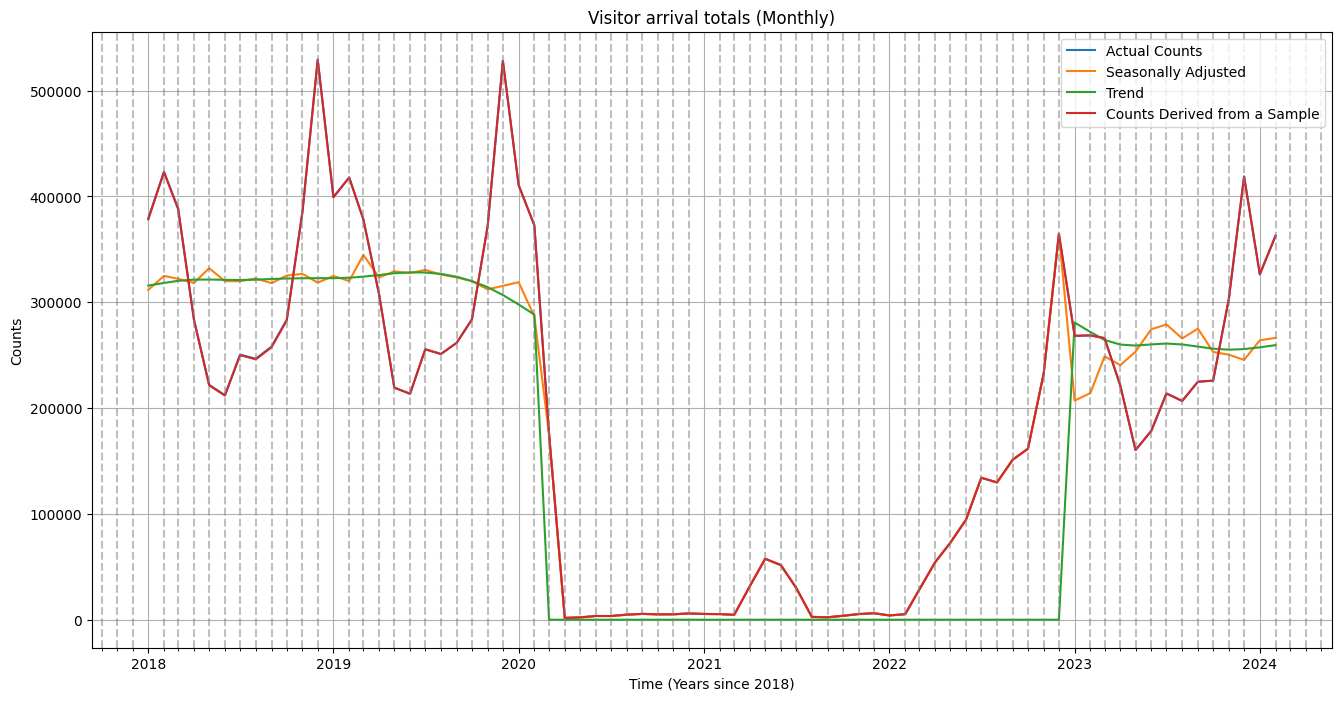

In [6]:
df1.set_index('Time', inplace=True)

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df1.index, df1['Actual Counts'], label='Actual Counts')
ax.plot(df1.index, df1['Seasonally Adjusted'], label='Seasonally Adjusted')
ax.plot(df1.index, df1['Trend'], label='Trend')
ax.plot(df1.index, df1['Counts Derived from a Sample'], label='Counts Derived from a Sample')

ax.set_xlabel('Time (Years since 2018)')
ax.set_ylabel('Counts')
ax.set_title('Visitor arrival totals (Monthly)')

ax.grid(True)
ax.legend()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())



for tick in ax.xaxis.get_minorticklocs():
    ax.axvline(x=tick, linestyle='--', color='grey', alpha=0.5)

plt.show()

In [7]:
pre_covid = df1['2018-01-01':'2020-02-01']
during_covid = df1['2020-03-01':'2022-12-01']
post_covid = df1['2023-01-01':'2024-02-01']

In [8]:
pre_stats = pre_covid.describe()
during_stats = during_covid.describe()
post_stats = post_covid.describe()

stats_df = pd.concat([pre_stats, during_stats, post_stats], axis=1, keys=['Pre-COVID', 'During-COVID', 'Post-COVID'])


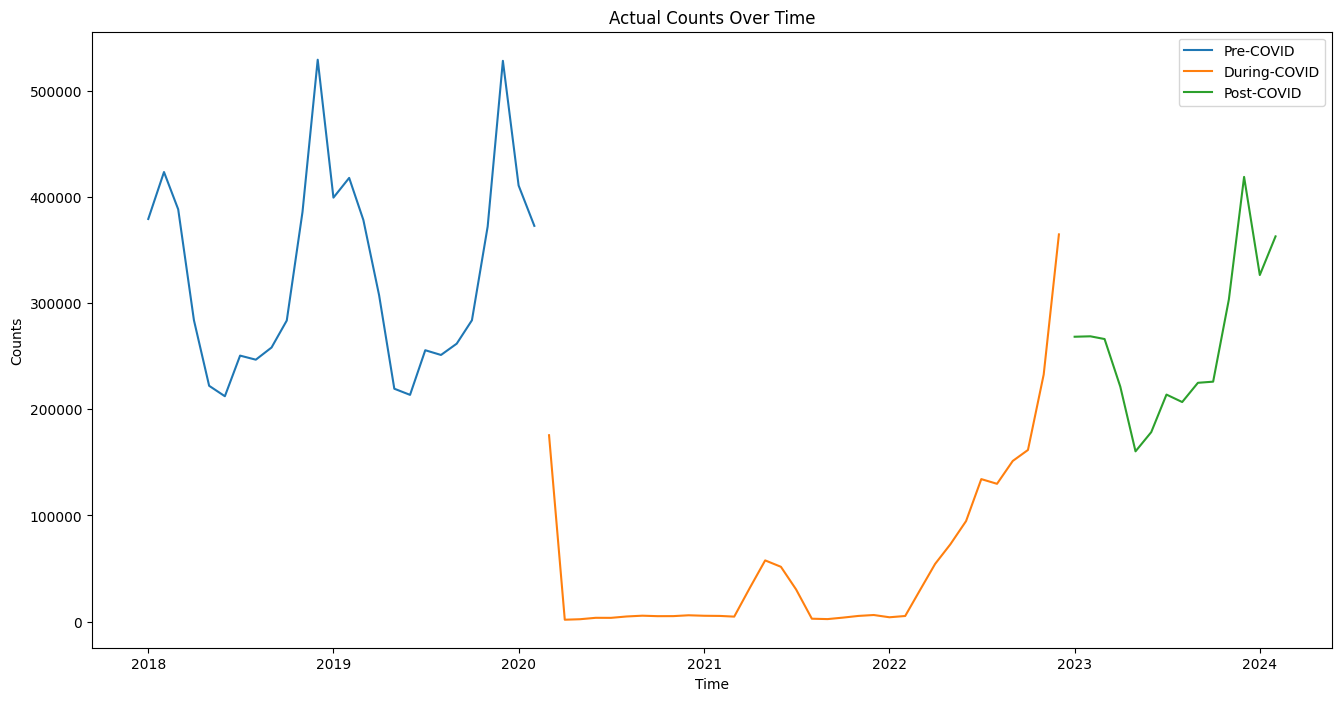

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(pre_covid['Actual Counts'], label='Pre-COVID')
plt.plot(during_covid['Actual Counts'], label='During-COVID')
plt.plot(post_covid['Actual Counts'], label='Post-COVID')
plt.title('Actual Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [10]:
pre_covid = pre_covid.drop('2020-02')
post_covid = post_covid.drop('2023-01')
combined_data = pd.concat([pre_covid, post_covid])
new_index = pd.date_range(start='2021-01-01', periods=len(combined_data), freq='MS')
combined_data.index = new_index


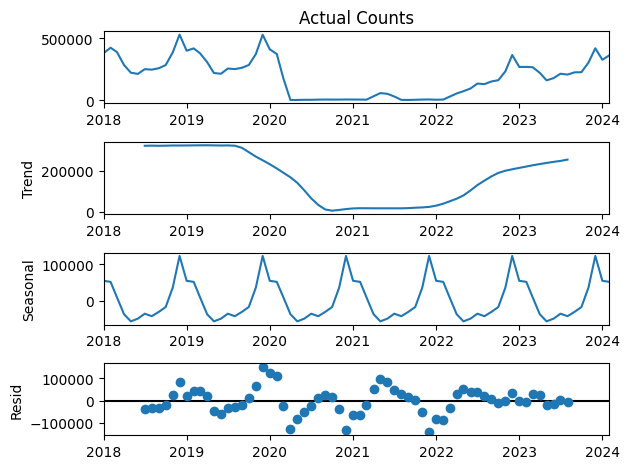

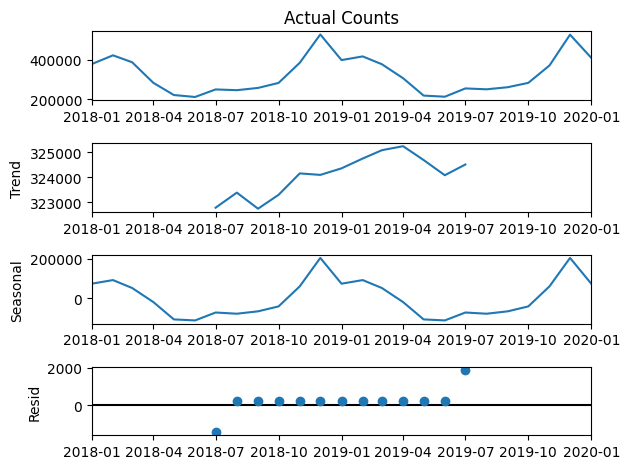

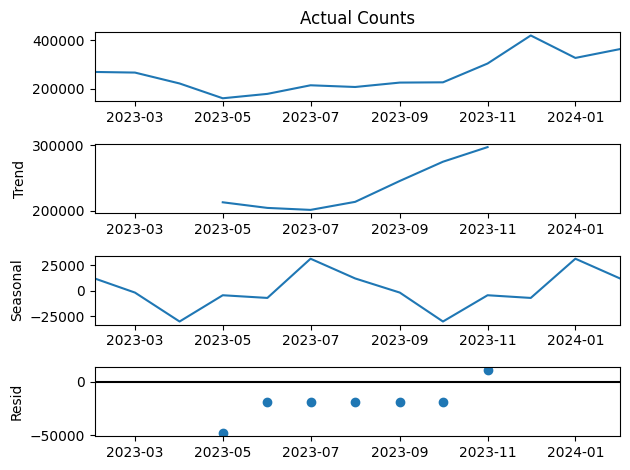

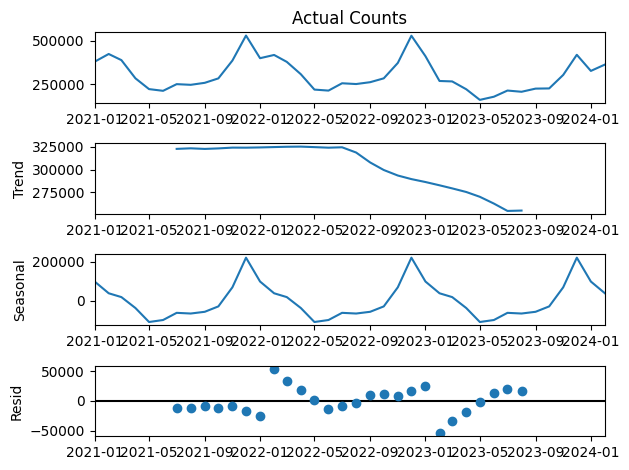

In [11]:
result = seasonal_decompose(df1['Actual Counts'], model='additive', period=12)
result.plot()
plt.show()

result_pre = seasonal_decompose(pre_covid['Actual Counts'], model='additive', period=12)
result_pre.plot()
plt.show()

result_post = seasonal_decompose(post_covid['Actual Counts'], model='additive', period=6)
result_post.plot()
plt.show()

result_combined_data = seasonal_decompose(combined_data['Actual Counts'], model='additive', period=12)
result_combined_data.plot()
plt.show()

In [12]:
df1.index = pd.date_range(start=df1.index.min(), periods=len(df1), freq='MS')
model_auto = auto_arima(df1['Actual Counts'], seasonal=True, m=12, stepwise=True, trace=False)

In [13]:
model_total = SARIMAX(df1['Actual Counts'], order=model_auto.order, seasonal_order=model_auto.seasonal_order)
model_total_fit = model_total.fit()
forecast_total = model_total_fit.forecast(steps=12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22621D+01    |proj g|=  1.31761D-01

At iterate    5    f=  1.22320D+01    |proj g|=  2.70092D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.701D-05   1.223D+01
  F =   12.231993137568574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [14]:
combined_data.index = pd.date_range(start=combined_data.index.min(), periods=len(combined_data), freq='MS')
model_auto_combined = auto_arima(combined_data['Actual Counts'], seasonal=True, m=12, stepwise=True, trace=False)

In [15]:
model_total_combined = SARIMAX(combined_data['Actual Counts'], order=model_auto_combined.order, seasonal_order=model_auto_combined.seasonal_order)
model_total_fit_combined = model_total_combined.fit()
forecast_total_combined = model_total_fit_combined.forecast(steps=12)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25999D+01    |proj g|=  1.13184D-01

At iterate    5    f=  1.24506D+01    |proj g|=  8.03646D-03

At iterate   10    f=  1.24466D+01    |proj g|=  1.22898D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   1.902D-05   1.245D+01
  F =   12.446405088383637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [16]:
mse_combined = mean_squared_error(combined_data['Actual Counts'][-12:], forecast_total_combined)
rmse_combined = np.sqrt(mse_combined)
mae_combined = mean_absolute_error(combined_data['Actual Counts'][-12:], forecast_total_combined)


mse = mean_squared_error(df1['Actual Counts'][-12:], forecast_total)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df1['Actual Counts'][-12:], forecast_total)



In [17]:
forecast_comparison = pd.DataFrame(index=pd.date_range(start=combined_data.index[-1], periods=13, freq='MS'))
forecast_comparison['Forecast_df1'] = forecast_total
forecast_comparison['Forecast_combined_data'] = forecast_total_combined

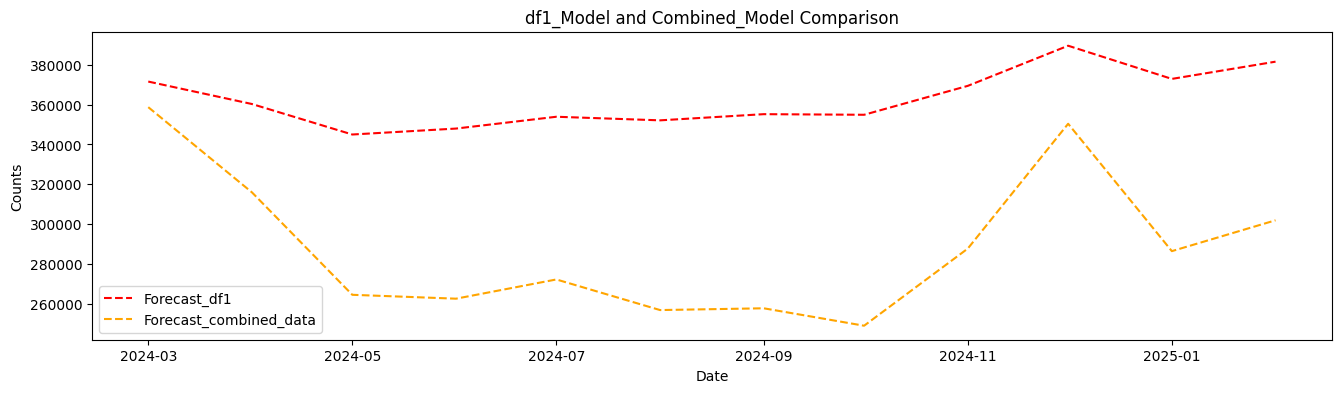

df1_Model RMSE: 120881.9861784668
df1_Model MAE: 108645.08871927876
Combined_Model RMSE: 66651.01314133879
Combined_Model MAE: 60457.044625436676


In [18]:
plt.figure(figsize=(16, 4))
plt.plot(forecast_comparison.index, forecast_comparison['Forecast_df1'], label='Forecast_df1', linestyle='--', color='red')
plt.plot(forecast_comparison.index, forecast_comparison['Forecast_combined_data'], label='Forecast_combined_data', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('df1_Model and Combined_Model Comparison')
plt.legend()
plt.show()
print("df1_Model RMSE:", rmse)
print("df1_Model MAE:", mae)
print("Combined_Model RMSE:", rmse_combined)
print("Combined_Model MAE:", mae_combined)

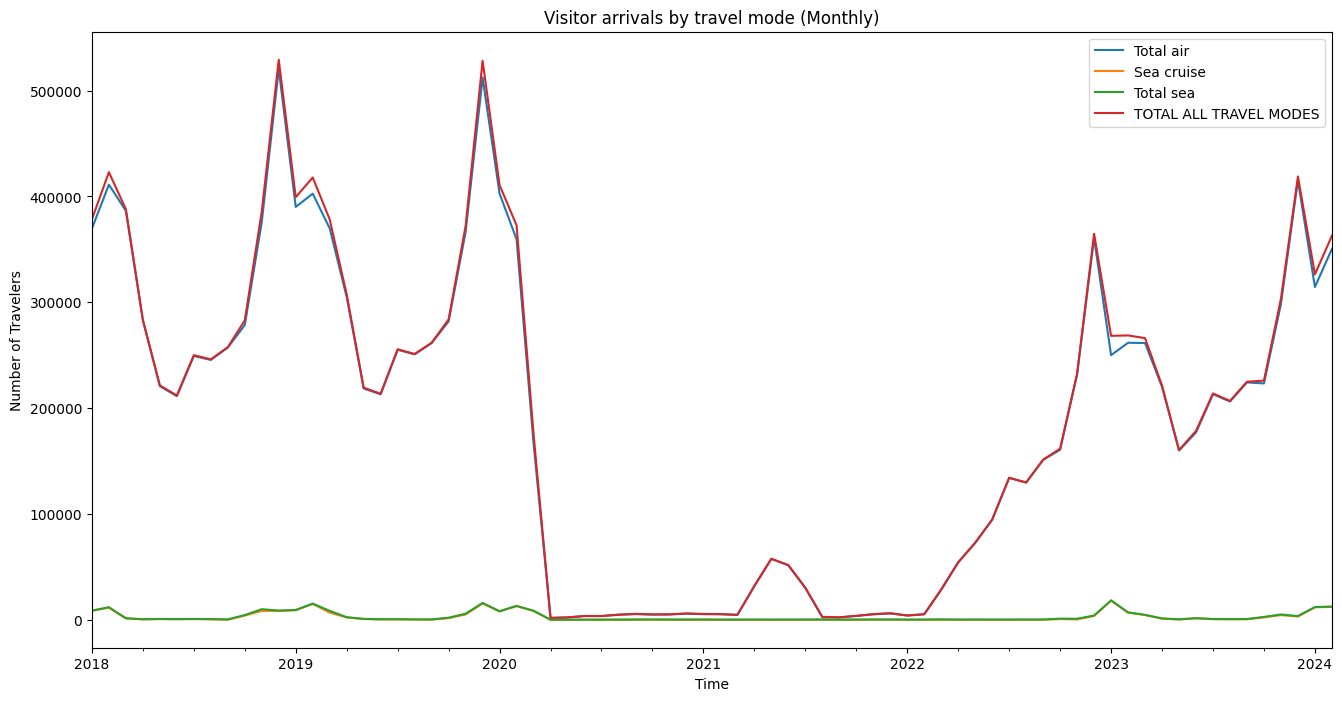

In [19]:
df4['Time'] = pd.to_datetime(df4['Time'])
df4.set_index('Time', inplace=True)
ax = df4[['Total air', 'Sea cruise', 'Total sea', 'TOTAL ALL TRAVEL MODES']].plot(figsize=(16, 8))
plt.title('Visitor arrivals by travel mode (Monthly)')
plt.ylabel('Number of Travelers')
plt.show()

# Analysis of the characteristics of overseas tourists

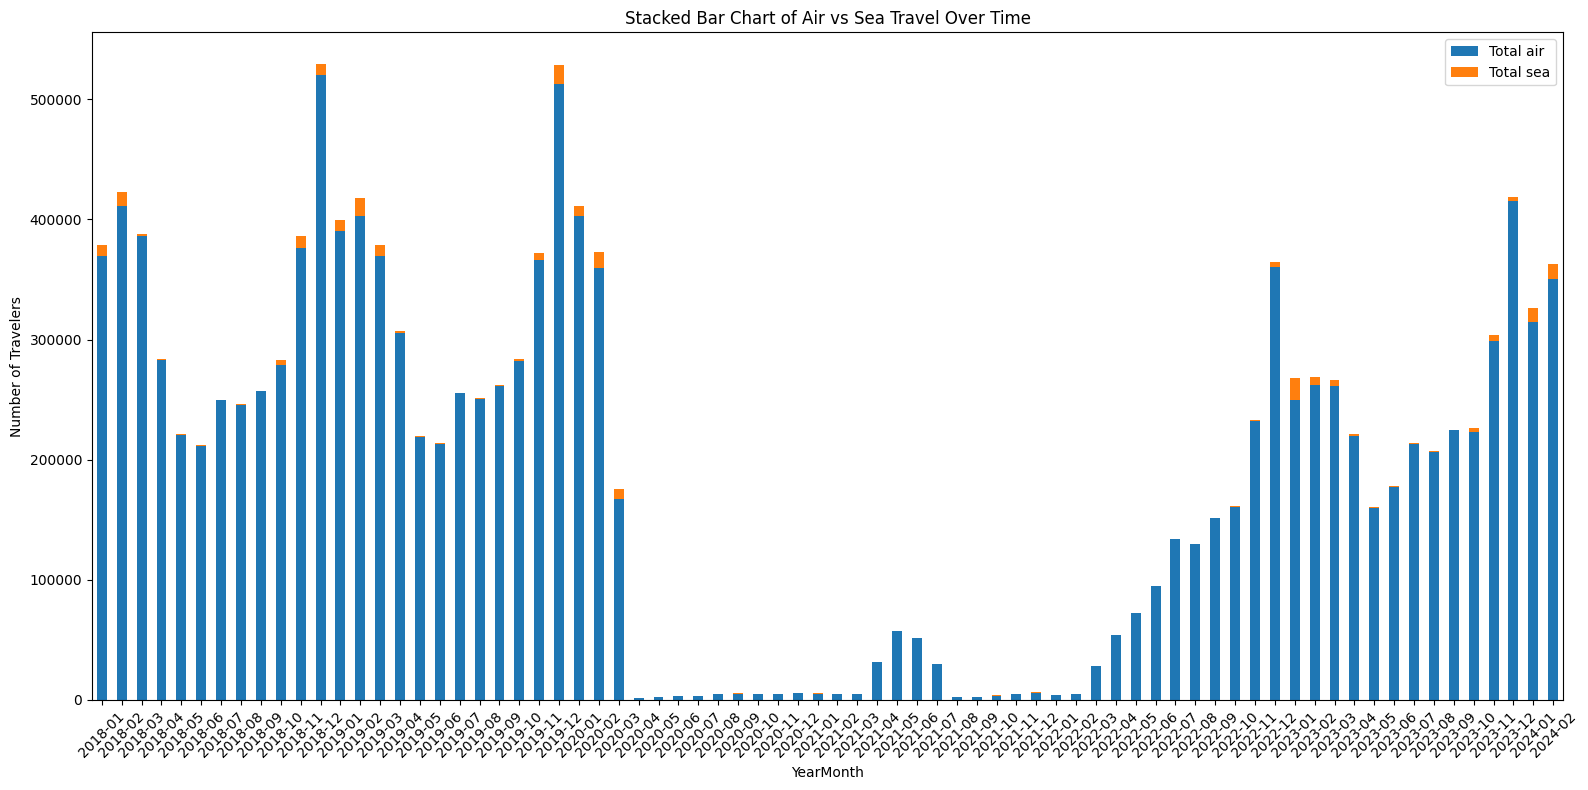

In [20]:
df4['YearMonth'] = df4.index.to_period('M').astype(str)

monthly_data = df4.groupby('YearMonth')[['Total air', 'Total sea']].sum()

fig, ax = plt.subplots(figsize=(16, 8))
monthly_data.plot(kind='bar', stacked=True, ax=ax)

plt.title('Stacked Bar Chart of Air vs Sea Travel Over Time')
plt.ylabel('Number of Travelers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


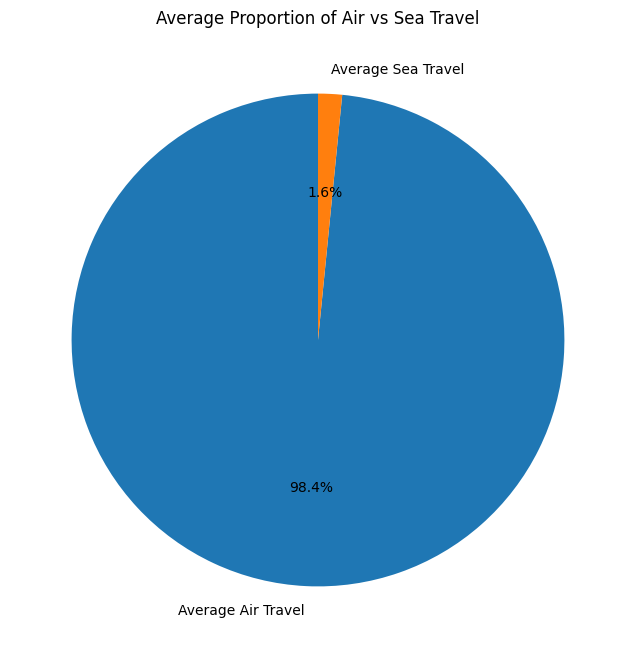

In [21]:
average_air = df4['Total air'].mean()
average_sea = df4['Total sea'].mean()

averages = [average_air, average_sea]
labels = ['Average Air Travel', 'Average Sea Travel']

plt.figure(figsize=(8, 8))
plt.pie(averages, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Average Proportion of Air vs Sea Travel')
plt.show()

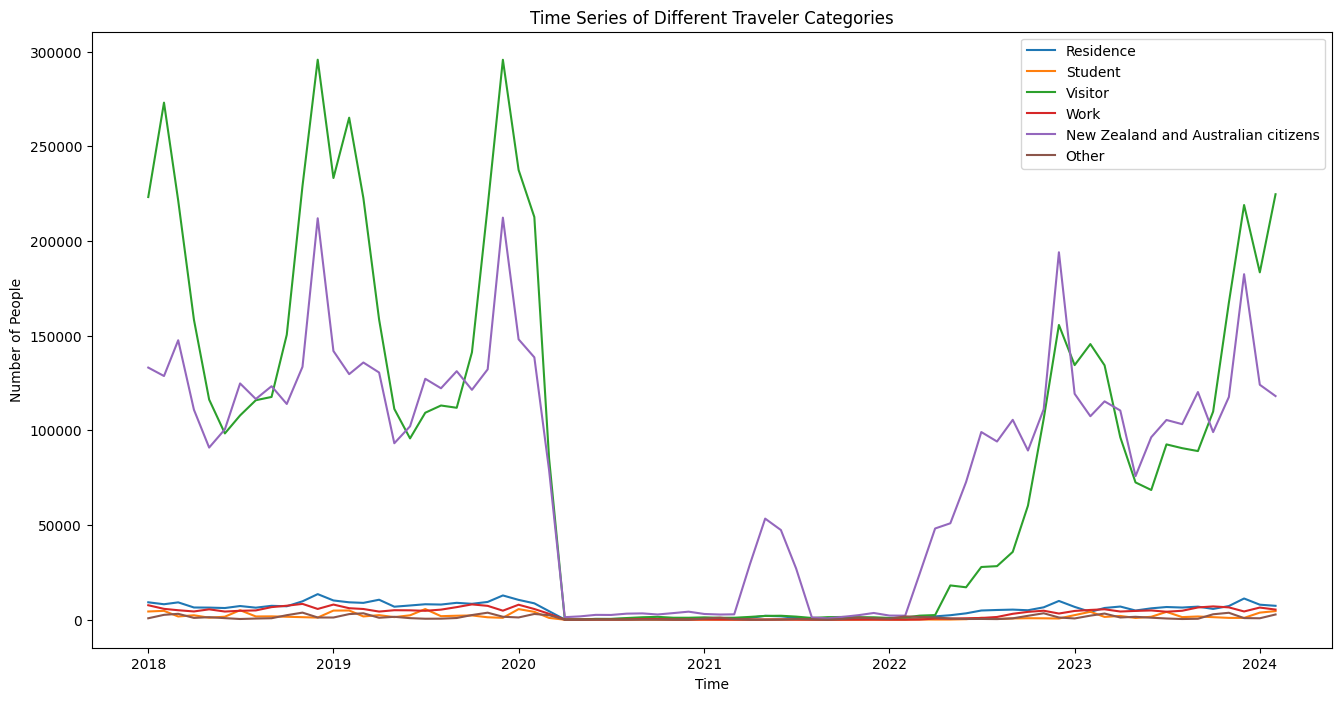

In [22]:
df5_All['Time'] = pd.to_datetime(df5_All['Time'])
df5_All.set_index('Time', inplace=True)

plt.figure(figsize=(16, 8))
plt.plot(df5_All['Residence'], label='Residence')
plt.plot(df5_All['Student'], label='Student')
plt.plot(df5_All['Visitor'], label='Visitor')
plt.plot(df5_All['Work'], label='Work')
plt.plot(df5_All['New Zealand and Australian citizens'], label='New Zealand and Australian citizens')
plt.plot(df5_All['Other'], label='Other')
plt.title('Time Series of Different Traveler Categories')
plt.xlabel('Time')
plt.ylabel('Number of People')
plt.legend()
plt.show()

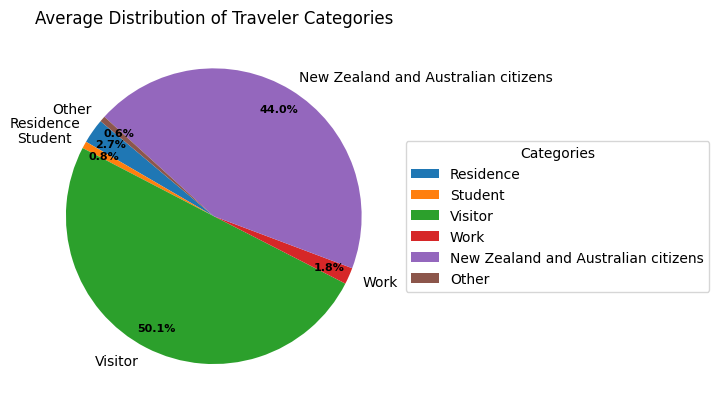

In [23]:
category_averages = df5_All[['Residence', 'Student', 'Visitor', 'Work', 'New Zealand and Australian citizens', 'Other']].mean()

data = category_averages.values
labels = category_averages.index

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(data, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

plt.setp(autotexts, size=8, weight="bold", color="black")
ax.set_title('Average Distribution of Traveler Categories')

plt.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

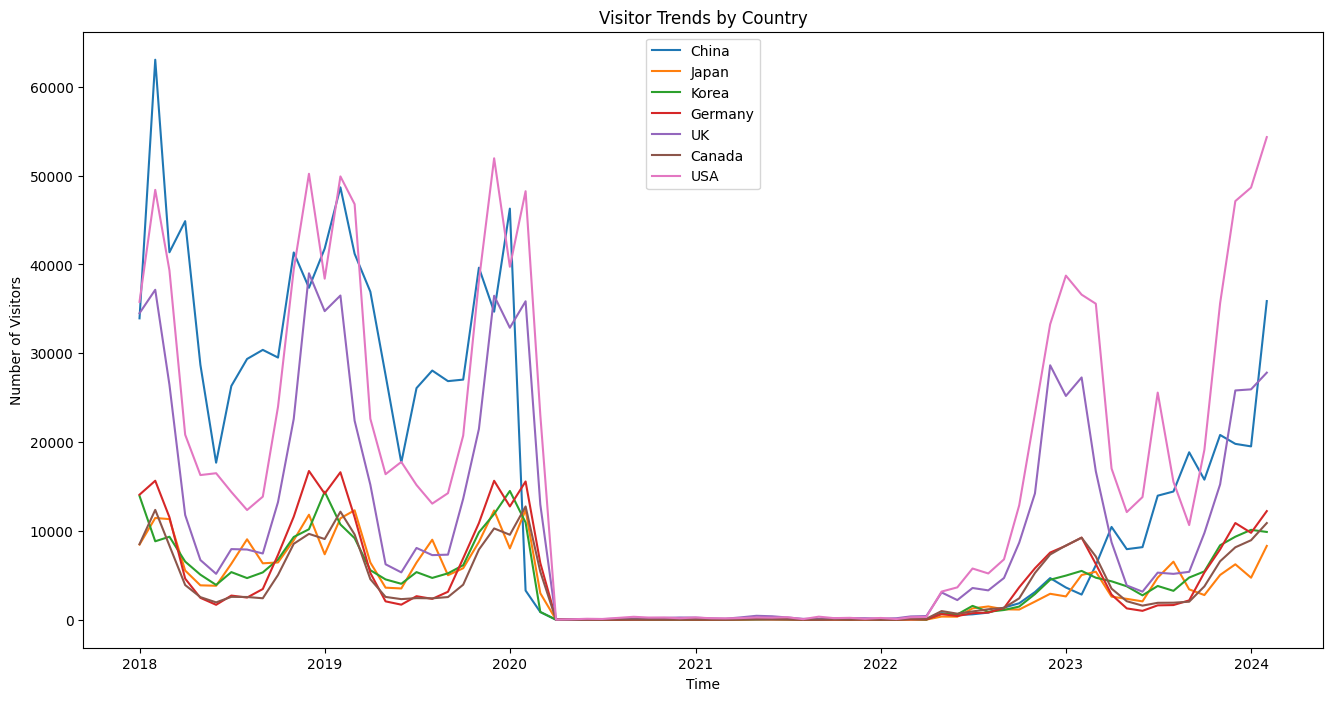

In [24]:
visitors = pd.DataFrame({
    'China': df5_China.set_index('Time')['Visitor'],
    'Japan': df5_Japan.set_index('Time')['Visitor'],
    'Korea': df5_Korea.set_index('Time')['Visitor'],
    'Germany': df5_Germany.set_index('Time')['Visitor'],
    'UK': df5_UK.set_index('Time')['Visitor'],
    'Canada': df5_Canada.set_index('Time')['Visitor'],
    'USA': df5_USA.set_index('Time')['Visitor'],
})

plt.figure(figsize=(16, 8))
for country in visitors.columns:
    plt.plot(visitors.index, visitors[country], label=country)

plt.title('Visitor Trends by Country')
plt.xlabel('Time')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()

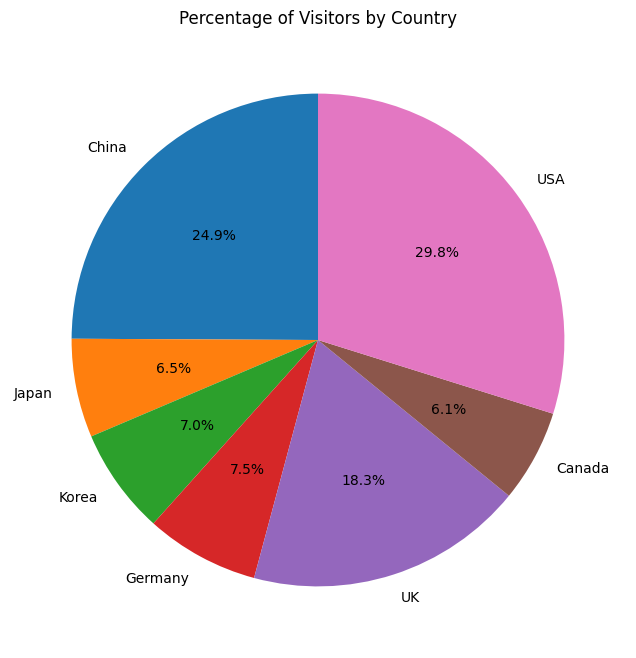

Top three countries by average visitors:
USA      17525.459459
China    14636.972973
UK       10741.121622
dtype: float64


In [25]:
average_visitors = visitors.mean()
top_three_countries = average_visitors.sort_values(ascending=False).head(3)

plt.figure(figsize=(10, 8))
plt.pie(average_visitors, labels=average_visitors.index, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Visitors by Country')
plt.show()

print("Top three countries by average visitors:")
print(top_three_countries)

In [26]:
df2.fillna(method='ffill', inplace=True)
df2.columns = ['_'.join(col).strip() if 'Unnamed' not in col[0] else '_'.join(col[1:]).strip() for col in df2.columns.values]
df2.rename(columns={df2.columns[0]: 'Time'}, inplace=True)

df2 = df2.melt(id_vars=[df2.columns[0]], var_name='Variable', value_name='Count')

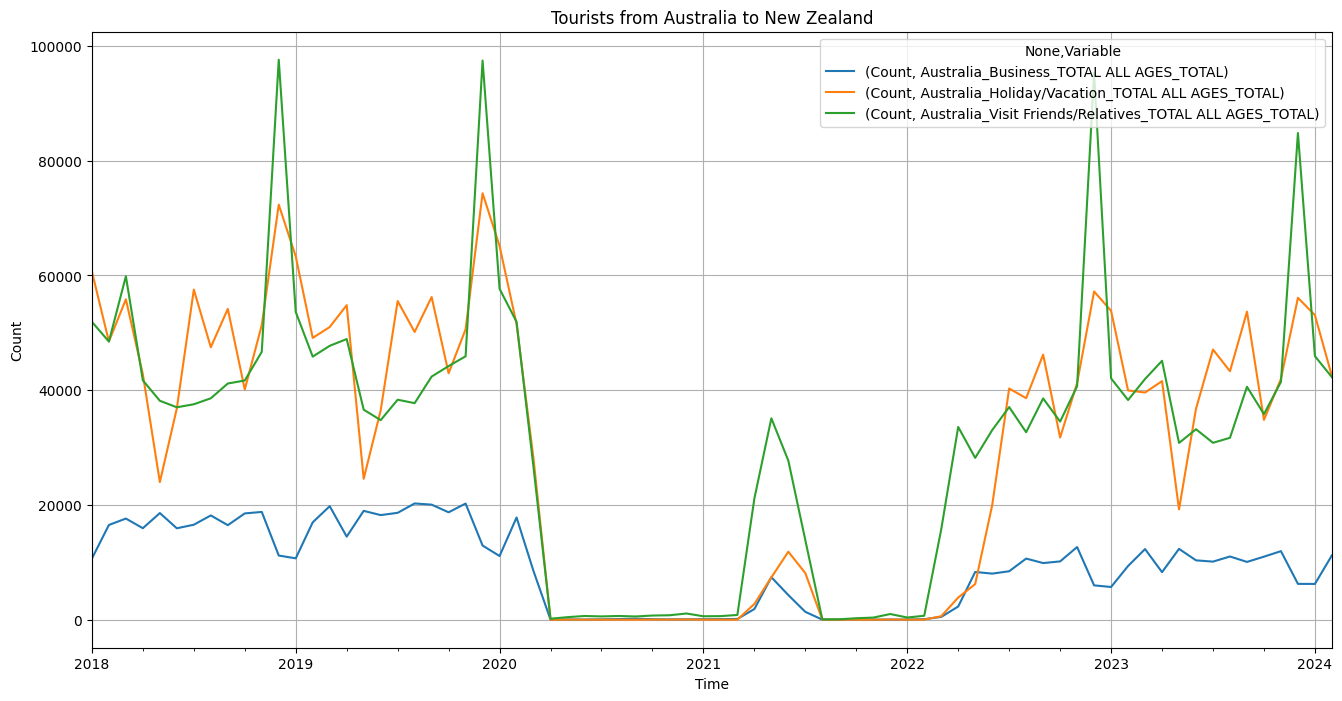

In [27]:
df_filtered = df2[df2['Variable'].str.contains("Australia_(?:Business|Holiday/Vacation|Visit Friends/Relatives)_TOTAL ALL AGES_TOTAL", regex=True)].copy()
df_filtered['Time'] = pd.to_datetime(df_filtered['Time'], format='%YM%m')
df_grouped = df_filtered.groupby(['Time', 'Variable']).sum().unstack()

ax = df_grouped.plot(kind='line', figsize=(16, 8)) 
plt.title('Tourists from Australia to New Zealand')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()


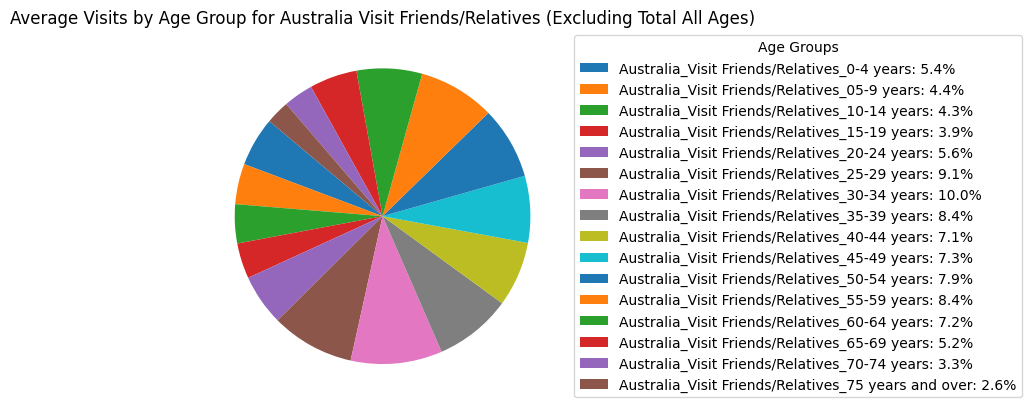

In [28]:
df_filtered = df2[(df2['Variable'].str.contains("Australia_Visit Friends/Relatives_.*_TOTAL")) & (~df2['Variable'].str.contains("TOTAL ALL AGES"))]

average_counts = df_filtered.groupby('Variable')['Count'].mean()


total = average_counts.sum()
percentages = (average_counts / total) * 100

labels = [f'{idx.split("_TOTAL")[0]}: {perc:.1f}%' for idx, perc in percentages.items()]

fig, ax = plt.subplots()
wedges, texts = ax.pie(average_counts, startangle=140) 

ax.legend(wedges, labels, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Average Visits by Age Group for Australia Visit Friends/Relatives (Excluding Total All Ages)')
plt.show()

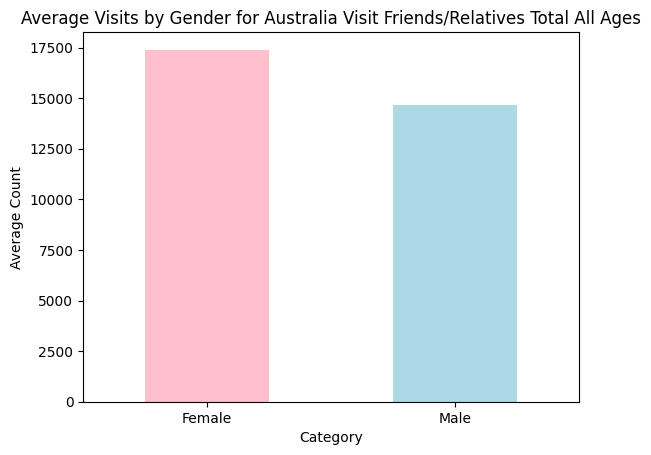

In [29]:
df_filtered = df2[df2['Variable'].str.contains("Australia_Visit Friends/Relatives_TOTAL ALL AGES") & ~df2['Variable'].str.contains("TOTAL$")]

average_counts = df_filtered.groupby('Variable')['Count'].mean()
average_counts = average_counts[average_counts.index.str.contains("Female|Male")]

x_labels = average_counts.index.str.split('_').str[-1]

fig, ax = plt.subplots()
average_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Average Visits by Gender for Australia Visit Friends/Relatives Total All Ages')
plt.xlabel('Category')
plt.ylabel('Average Count')
plt.xticks(range(len(x_labels)), x_labels, rotation=0) 
plt.show()

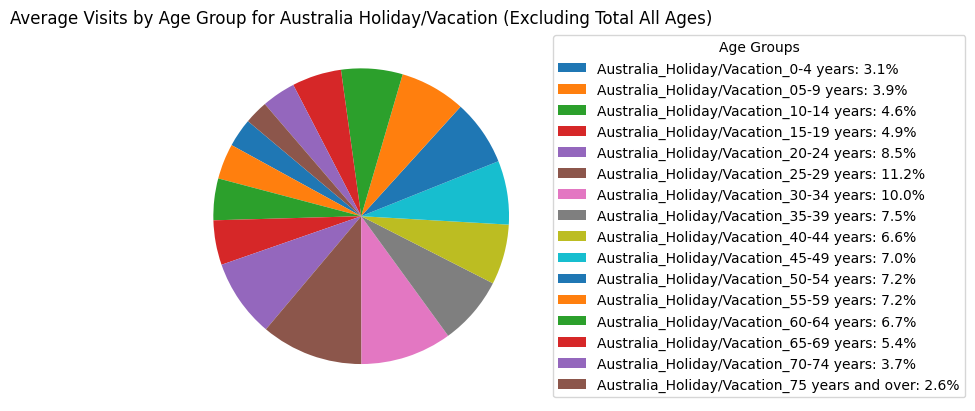

In [30]:
df_filtered = df2[(df2['Variable'].str.contains("Australia_Holiday/Vacation_.*_TOTAL")) & (~df2['Variable'].str.contains("TOTAL ALL AGES"))]

average_counts = df_filtered.groupby('Variable')['Count'].mean()

total = average_counts.sum()
percentages = (average_counts / total) * 100

labels = [f'{idx.split("_TOTAL")[0]}: {perc:.1f}%' for idx, perc in percentages.items()]

fig, ax = plt.subplots()
wedges, texts = ax.pie(average_counts, startangle=140)

ax.legend(wedges, labels, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Average Visits by Age Group for Australia Holiday/Vacation (Excluding Total All Ages)')
plt.show()

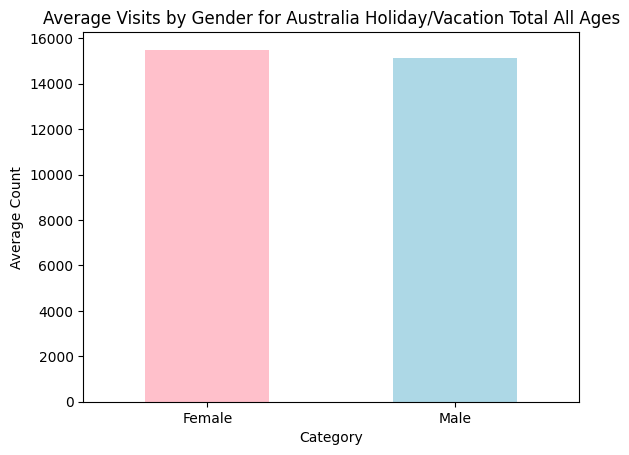

In [31]:
df_filtered = df2[df2['Variable'].str.contains("Australia_Holiday/Vacation_TOTAL ALL AGES") & ~df2['Variable'].str.contains("TOTAL$")]

average_counts = df_filtered.groupby('Variable')['Count'].mean()
average_counts = average_counts[average_counts.index.str.contains("Female|Male")]

x_labels = average_counts.index.str.split('_').str[-1]
fig, ax = plt.subplots()
average_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Average Visits by Gender for Australia Holiday/Vacation Total All Ages')
plt.xlabel('Category')
plt.ylabel('Average Count')
plt.xticks(range(len(x_labels)), x_labels, rotation=0) 
plt.show()

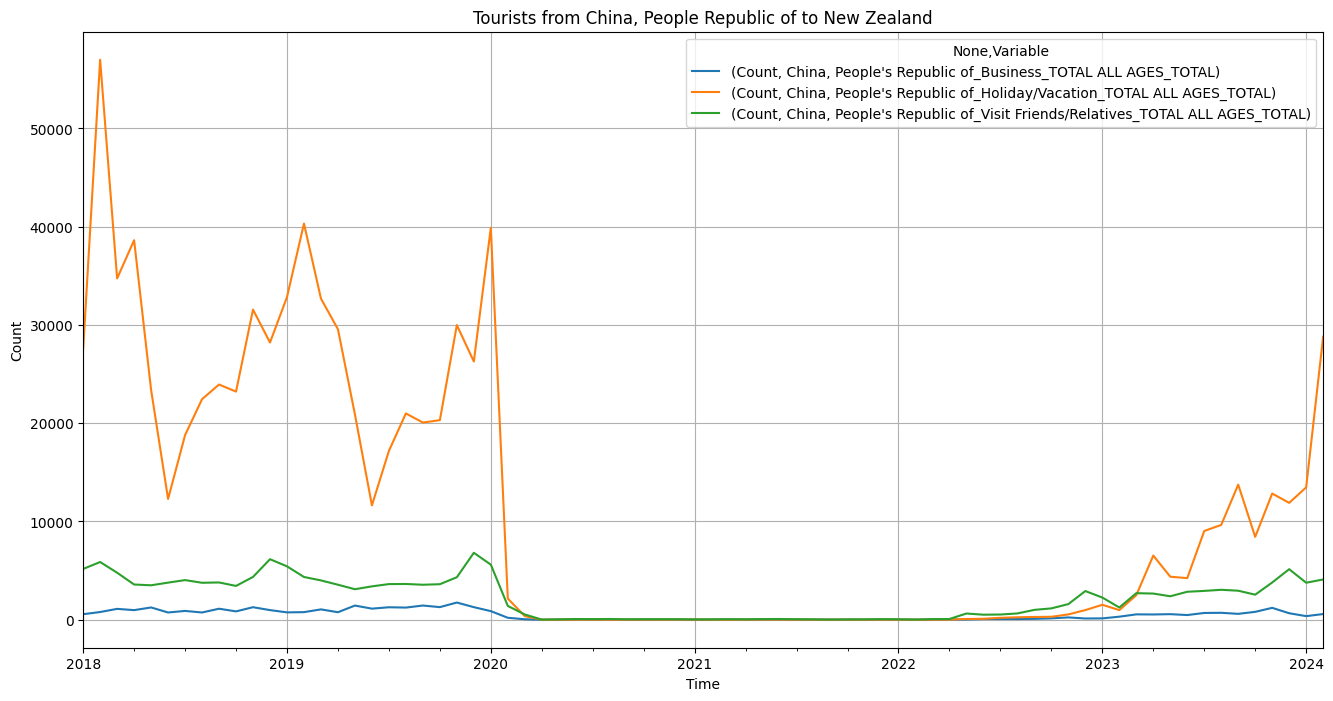

In [32]:
df_filtered = df2[df2['Variable'].str.contains("China, People's Republic of_(?:Business|Holiday/Vacation|Visit Friends/Relatives)_TOTAL ALL AGES_TOTAL", regex=True)].copy()
df_filtered['Time'] = pd.to_datetime(df_filtered['Time'], format='%YM%m')
df_grouped = df_filtered.groupby(['Time', 'Variable']).sum().unstack()
ax = df_grouped.plot(kind='line', figsize=(16, 8))
plt.title('Tourists from China, People Republic of to New Zealand')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()


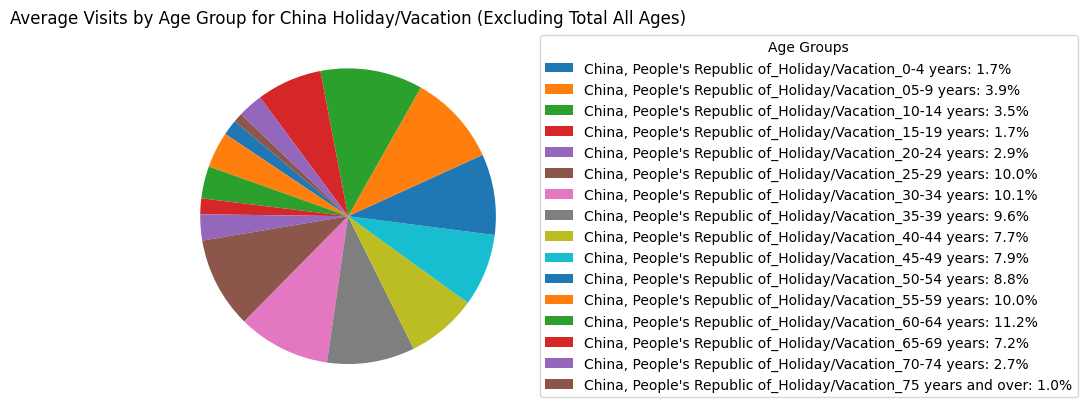

In [33]:
df_filtered = df2[(df2['Variable'].str.contains("China, People's Republic of_Holiday/Vacation_.*_TOTAL")) & (~df2['Variable'].str.contains("TOTAL ALL AGES"))]
average_counts = df_filtered.groupby('Variable')['Count'].mean()
total = average_counts.sum()
percentages = (average_counts / total) * 100

labels = [f'{idx.split("_TOTAL")[0]}: {perc:.1f}%' for idx, perc in percentages.items()]

fig, ax = plt.subplots()
wedges, texts = ax.pie(average_counts, startangle=140) 
ax.legend(wedges, labels, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Average Visits by Age Group for China Holiday/Vacation (Excluding Total All Ages)')
plt.show()

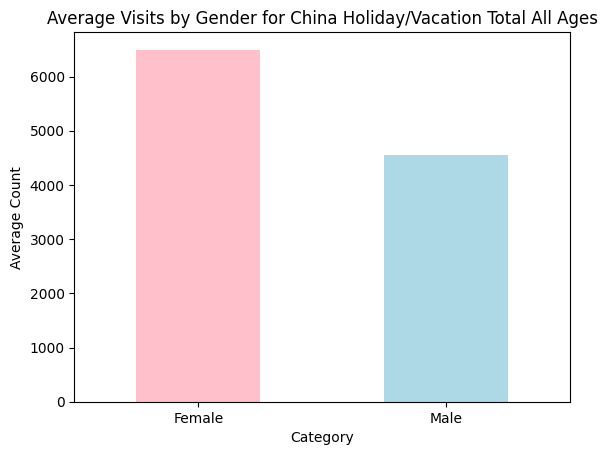

In [34]:
df_filtered = df2[df2['Variable'].str.contains("China, People's Republic of_Holiday/Vacation_TOTAL ALL AGES") & ~df2['Variable'].str.contains("TOTAL$")]
average_counts = df_filtered.groupby('Variable')['Count'].mean()
average_counts = average_counts[average_counts.index.str.contains("Female|Male")]
x_labels = average_counts.index.str.split('_').str[-1]
fig, ax = plt.subplots()
average_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Average Visits by Gender for China Holiday/Vacation Total All Ages')
plt.xlabel('Category')
plt.ylabel('Average Count')
plt.xticks(range(len(x_labels)), x_labels, rotation=0)  
plt.show()

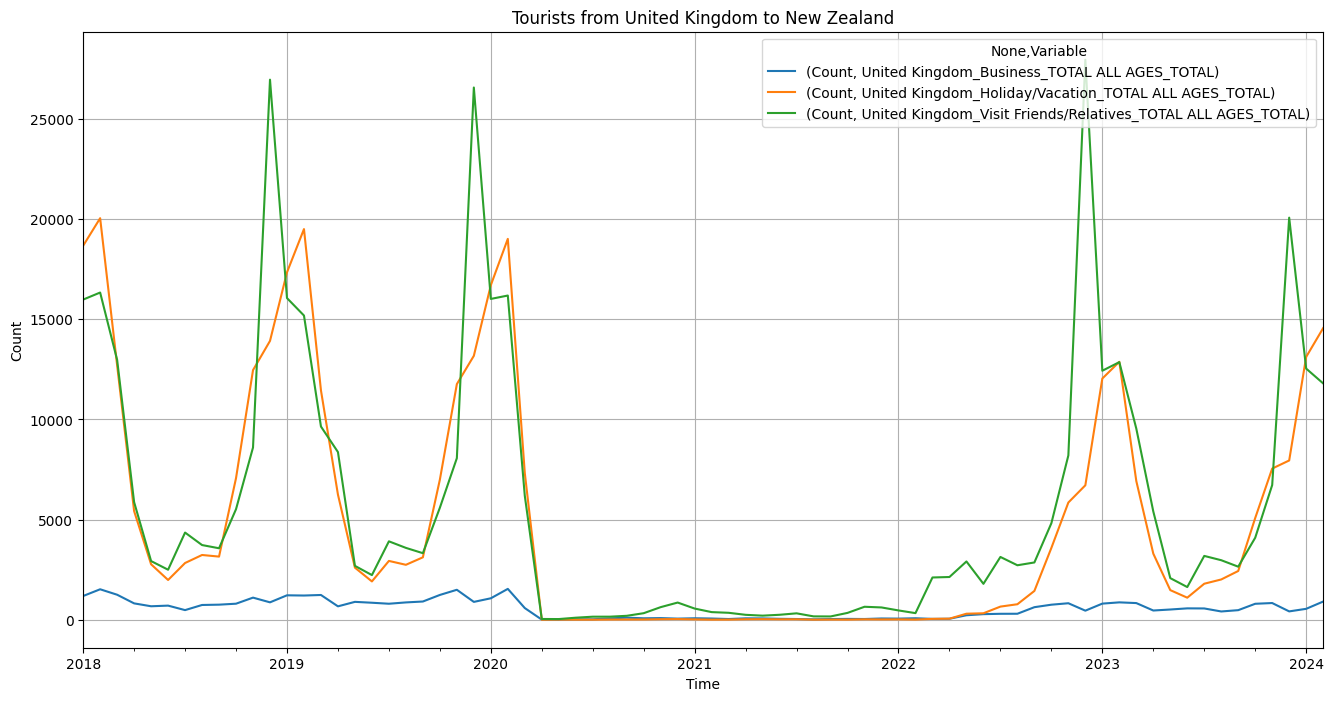

In [35]:
df_filtered = df2[df2['Variable'].str.contains("United Kingdom_(?:Business|Holiday/Vacation|Visit Friends/Relatives)_TOTAL ALL AGES_TOTAL", regex=True)].copy()
df_filtered['Time'] = pd.to_datetime(df_filtered['Time'], format='%YM%m')
df_grouped = df_filtered.groupby(['Time', 'Variable']).sum().unstack()
ax = df_grouped.plot(kind='line', figsize=(16, 8))
plt.title('Tourists from United Kingdom to New Zealand')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()


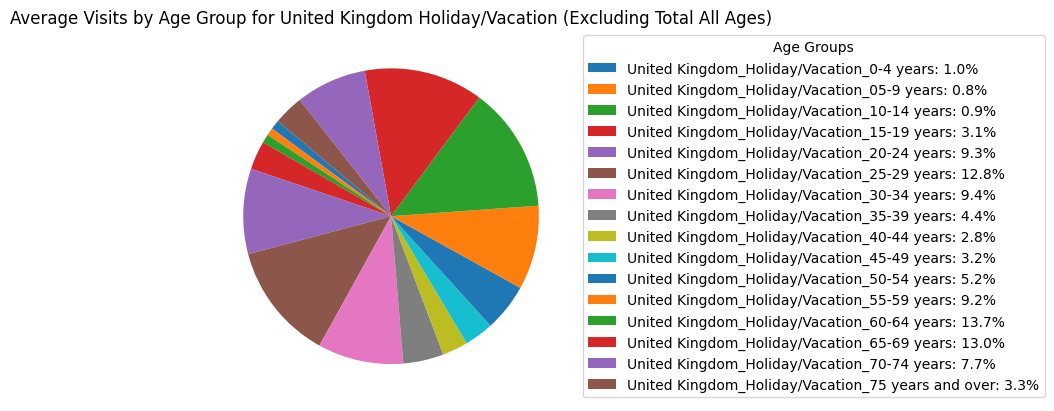

In [36]:
df_filtered = df2[(df2['Variable'].str.contains("United Kingdom_Holiday/Vacation_.*_TOTAL")) & (~df2['Variable'].str.contains("TOTAL ALL AGES"))]
average_counts = df_filtered.groupby('Variable')['Count'].mean()

total = average_counts.sum()
percentages = (average_counts / total) * 100

labels = [f'{idx.split("_TOTAL")[0]}: {perc:.1f}%' for idx, perc in percentages.items()]

fig, ax = plt.subplots()
wedges, texts = ax.pie(average_counts, startangle=140)  
ax.legend(wedges, labels, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Average Visits by Age Group for United Kingdom Holiday/Vacation (Excluding Total All Ages)')
plt.show()

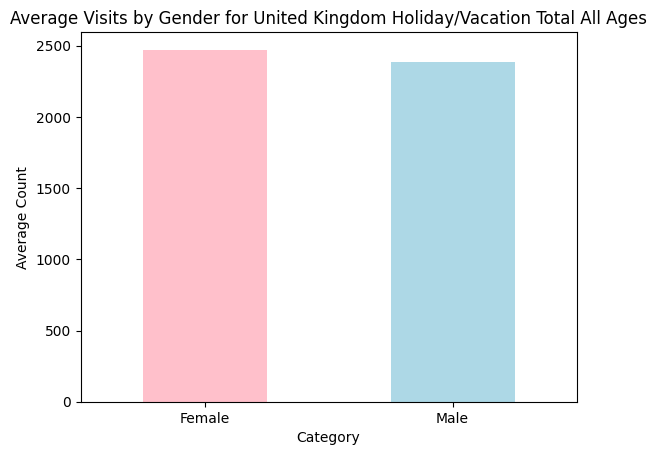

In [37]:
df_filtered = df2[df2['Variable'].str.contains("United Kingdom_Holiday/Vacation_TOTAL ALL AGES") & ~df2['Variable'].str.contains("TOTAL$")]

average_counts = df_filtered.groupby('Variable')['Count'].mean()
average_counts = average_counts[average_counts.index.str.contains("Female|Male")]

x_labels = average_counts.index.str.split('_').str[-1]

fig, ax = plt.subplots()
average_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Average Visits by Gender for United Kingdom Holiday/Vacation Total All Ages')
plt.xlabel('Category')
plt.ylabel('Average Count')
plt.xticks(range(len(x_labels)), x_labels, rotation=0) 
plt.show()

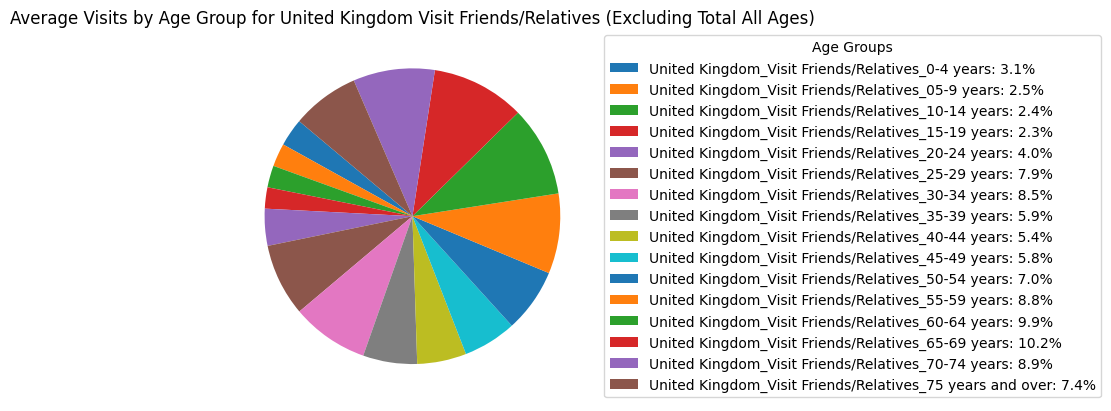

In [38]:
df_filtered = df2[(df2['Variable'].str.contains("United Kingdom_Visit Friends/Relatives_.*_TOTAL")) & (~df2['Variable'].str.contains("TOTAL ALL AGES"))]
average_counts = df_filtered.groupby('Variable')['Count'].mean()
total = average_counts.sum()
percentages = (average_counts / total) * 100
labels = [f'{idx.split("_TOTAL")[0]}: {perc:.1f}%' for idx, perc in percentages.items()]
fig, ax = plt.subplots()
wedges, texts = ax.pie(average_counts, startangle=140) 

ax.legend(wedges, labels, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Average Visits by Age Group for United Kingdom Visit Friends/Relatives (Excluding Total All Ages)')
plt.show()

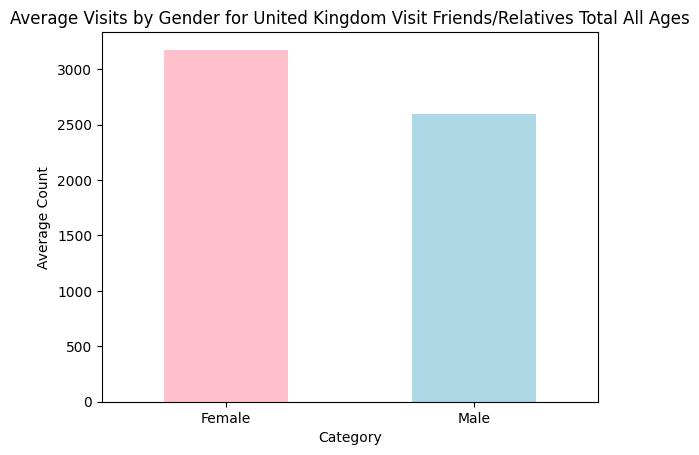

In [39]:
df_filtered = df2[df2['Variable'].str.contains("United Kingdom_Visit Friends/Relatives_TOTAL ALL AGES") & ~df2['Variable'].str.contains("TOTAL$")]

average_counts = df_filtered.groupby('Variable')['Count'].mean()

average_counts = average_counts[average_counts.index.str.contains("Female|Male")]

x_labels = average_counts.index.str.split('_').str[-1]

fig, ax = plt.subplots()
average_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Average Visits by Gender for United Kingdom Visit Friends/Relatives Total All Ages')
plt.xlabel('Category')
plt.ylabel('Average Count')
plt.xticks(range(len(x_labels)), x_labels, rotation=0)  
plt.show()

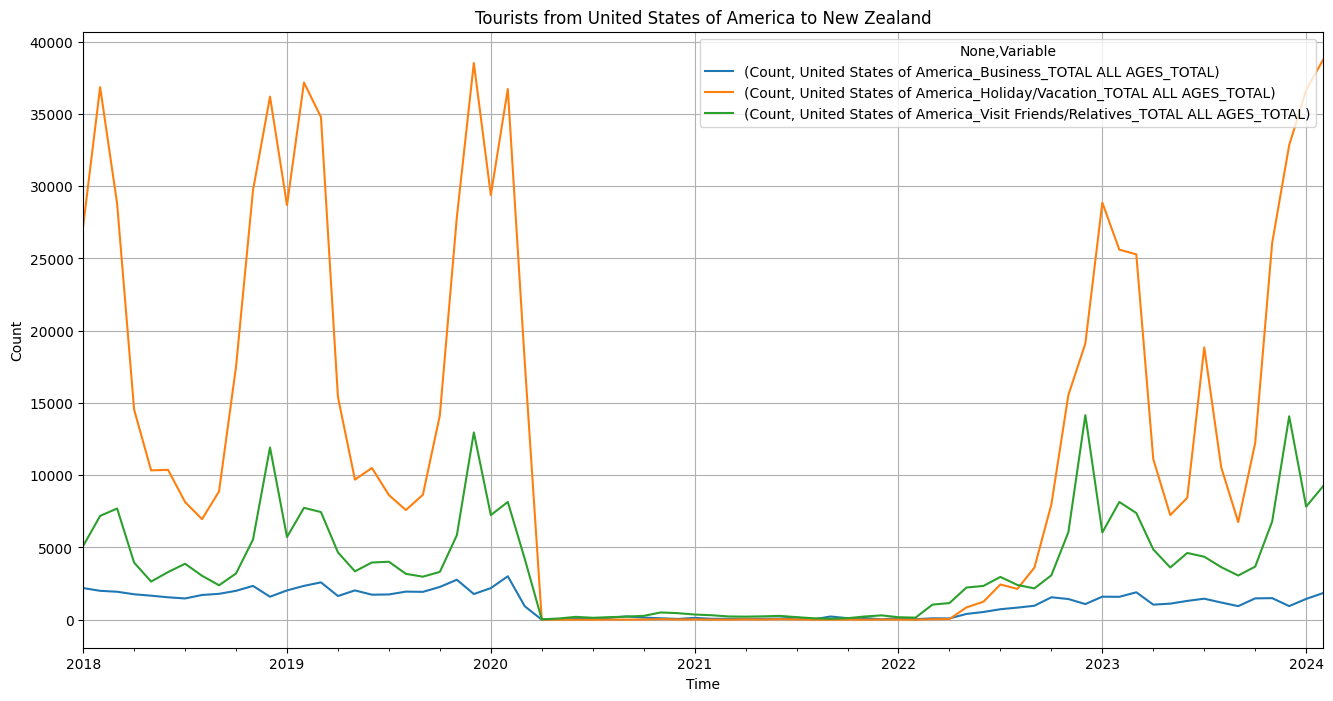

In [40]:
df_filtered = df2[df2['Variable'].str.contains("United States of America_(?:Business|Holiday/Vacation|Visit Friends/Relatives)_TOTAL ALL AGES_TOTAL", regex=True)].copy()

df_filtered['Time'] = pd.to_datetime(df_filtered['Time'], format='%YM%m')

df_grouped = df_filtered.groupby(['Time', 'Variable']).sum().unstack()


ax = df_grouped.plot(kind='line', figsize=(16, 8))
plt.title('Tourists from United States of America to New Zealand')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()


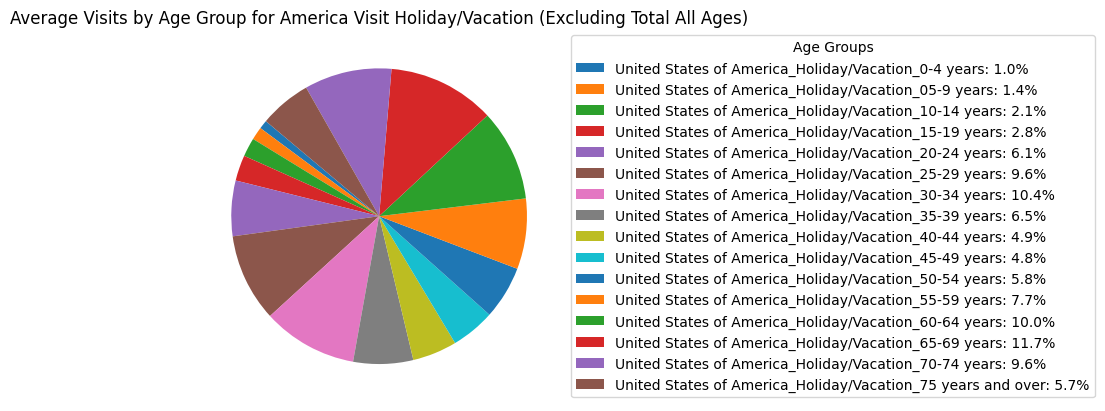

In [41]:
df_filtered = df2[(df2['Variable'].str.contains("United States of America_Holiday/Vacation_.*_TOTAL")) & (~df2['Variable'].str.contains("TOTAL ALL AGES"))]

average_counts = df_filtered.groupby('Variable')['Count'].mean()

total = average_counts.sum()
percentages = (average_counts / total) * 100

labels = [f'{idx.split("_TOTAL")[0]}: {perc:.1f}%' for idx, perc in percentages.items()]

fig, ax = plt.subplots()
wedges, texts = ax.pie(average_counts, startangle=140)

ax.legend(wedges, labels, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Average Visits by Age Group for America Visit Holiday/Vacation (Excluding Total All Ages)')
plt.show()

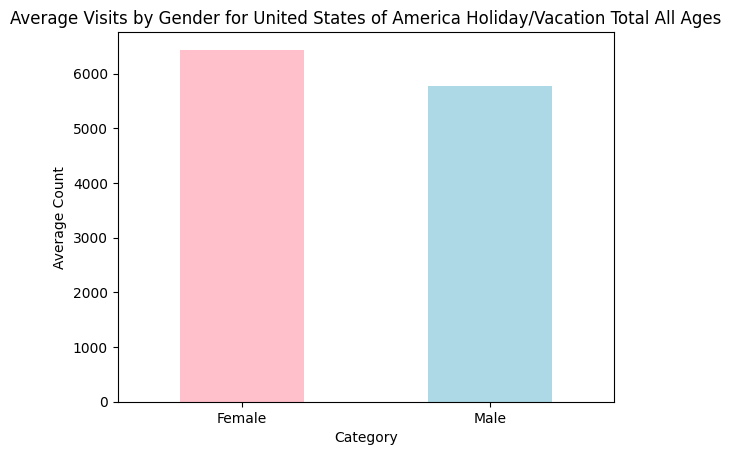

In [42]:
df_filtered = df2[df2['Variable'].str.contains("United States of America_Holiday/Vacation_TOTAL ALL AGES") & ~df2['Variable'].str.contains("TOTAL$")]

average_counts = df_filtered.groupby('Variable')['Count'].mean()

average_counts = average_counts[average_counts.index.str.contains("Female|Male")]

x_labels = average_counts.index.str.split('_').str[-1]

fig, ax = plt.subplots()
average_counts.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Average Visits by Gender for United States of America Holiday/Vacation Total All Ages')
plt.xlabel('Category')
plt.ylabel('Average Count')
plt.xticks(range(len(x_labels)), x_labels, rotation=0) 
plt.show()

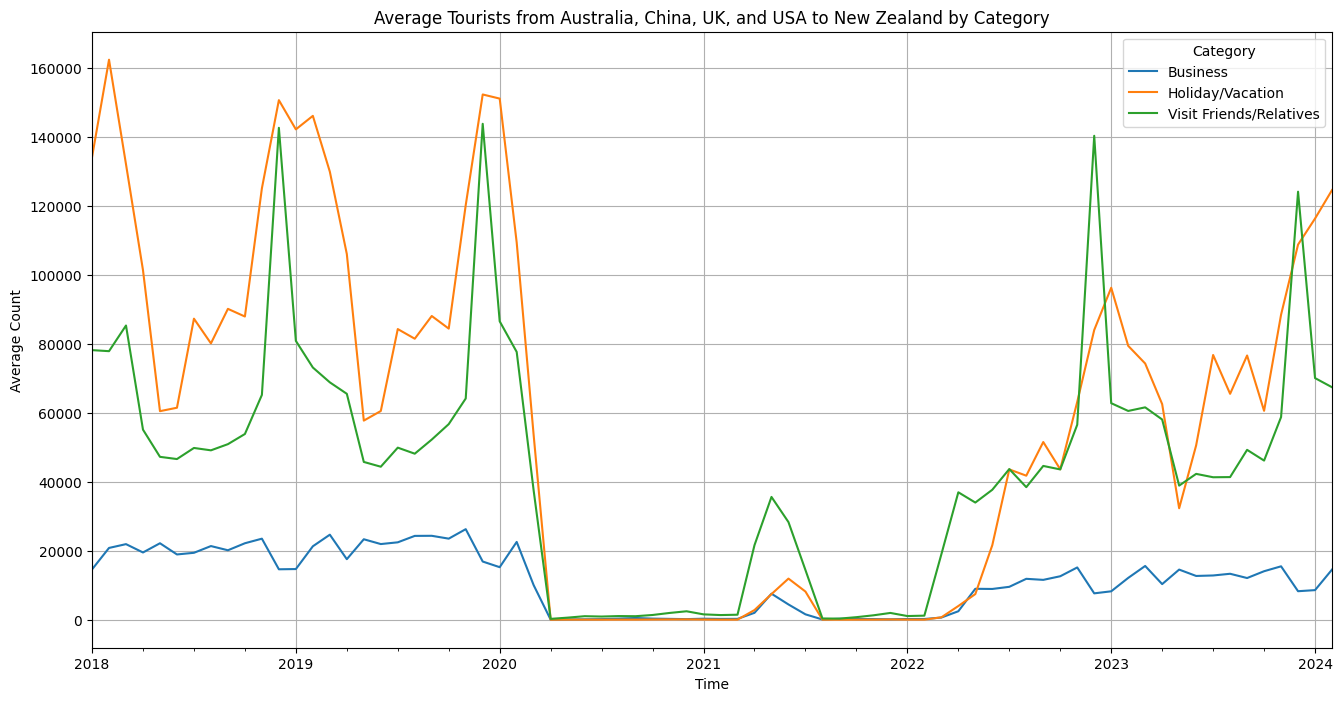

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))

categories = ['Business', 'Holiday/Vacation', 'Visit Friends/Relatives']
countries = ['Australia', 'China, People\'s Republic of', 'United Kingdom', 'United States of America']
df_list = []

for country in countries:
    for category in categories:
        regex = f"{country}_(?:{category})_TOTAL ALL AGES_TOTAL"
        df_filtered = df2[df2['Variable'].str.contains(regex, regex=True)].copy()
        df_filtered['Time'] = pd.to_datetime(df_filtered['Time'], format='%YM%m')
        df_filtered['Country'] = country 
        df_filtered['Category'] = category  
        df_list.append(df_filtered)

df_combined = pd.concat(df_list)
df_grouped = df_combined.groupby(['Time', 'Category']).sum(numeric_only=True).unstack()
df_grouped.columns = df_grouped.columns.droplevel()
df_mean = df_grouped.groupby('Time').mean()
df_mean.plot(ax=ax)
plt.title('Average Tourists from Australia, China, UK, and USA to New Zealand by Category')
plt.xlabel('Time')
plt.ylabel('Average Count')
plt.grid(True)
plt.legend(title='Category')
plt.show()

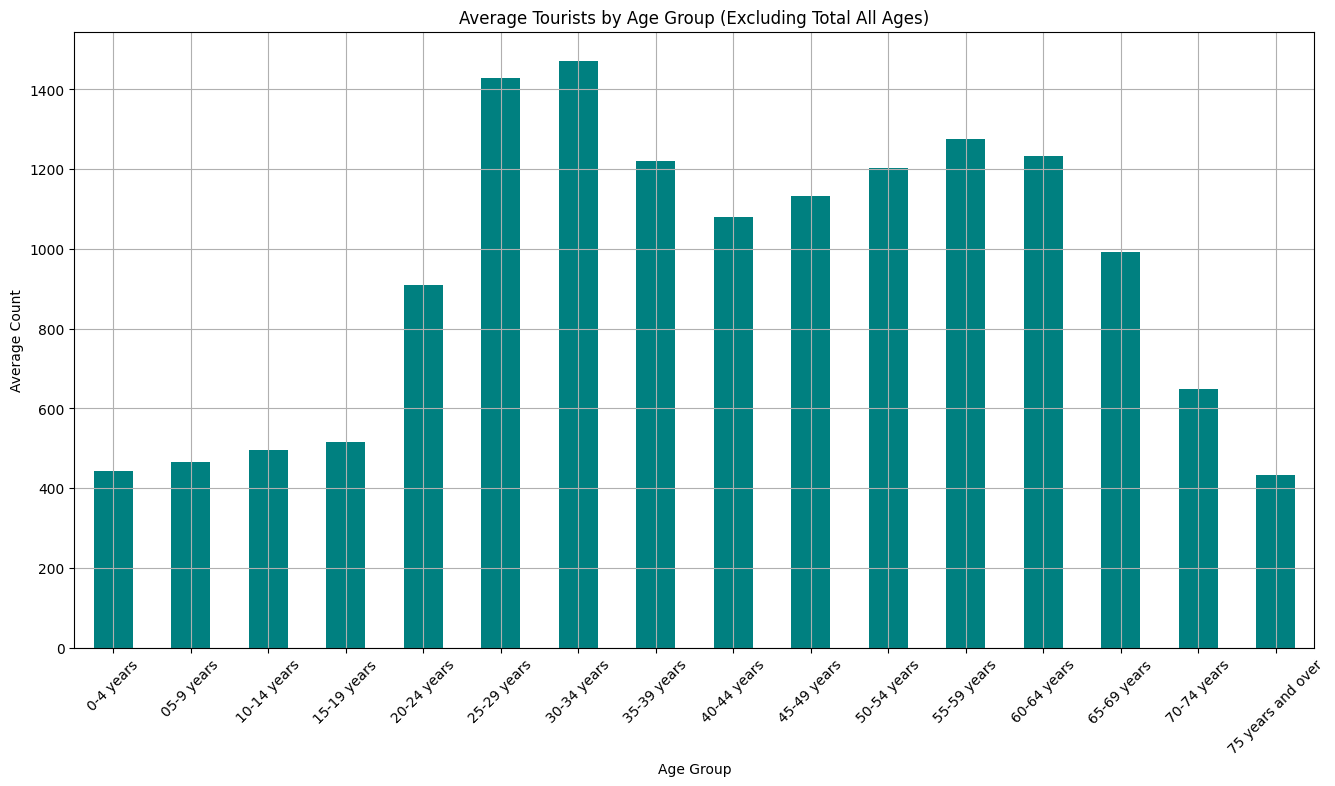

In [44]:
df_filtered = df2[~df2['Variable'].str.contains("TOTAL ALL AGES")].copy()
df_filtered.loc[:, 'Age Group'] = df_filtered['Variable'].str.extract(r'_([^_]+)_TOTAL$')[0]
average_counts = df_filtered.groupby('Age Group')['Count'].mean()
fig, ax = plt.subplots(figsize=(16, 8))
average_counts.plot(kind='bar', ax=ax, color='teal')

plt.title('Average Tourists by Age Group (Excluding Total All Ages)')
plt.xlabel('Age Group')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

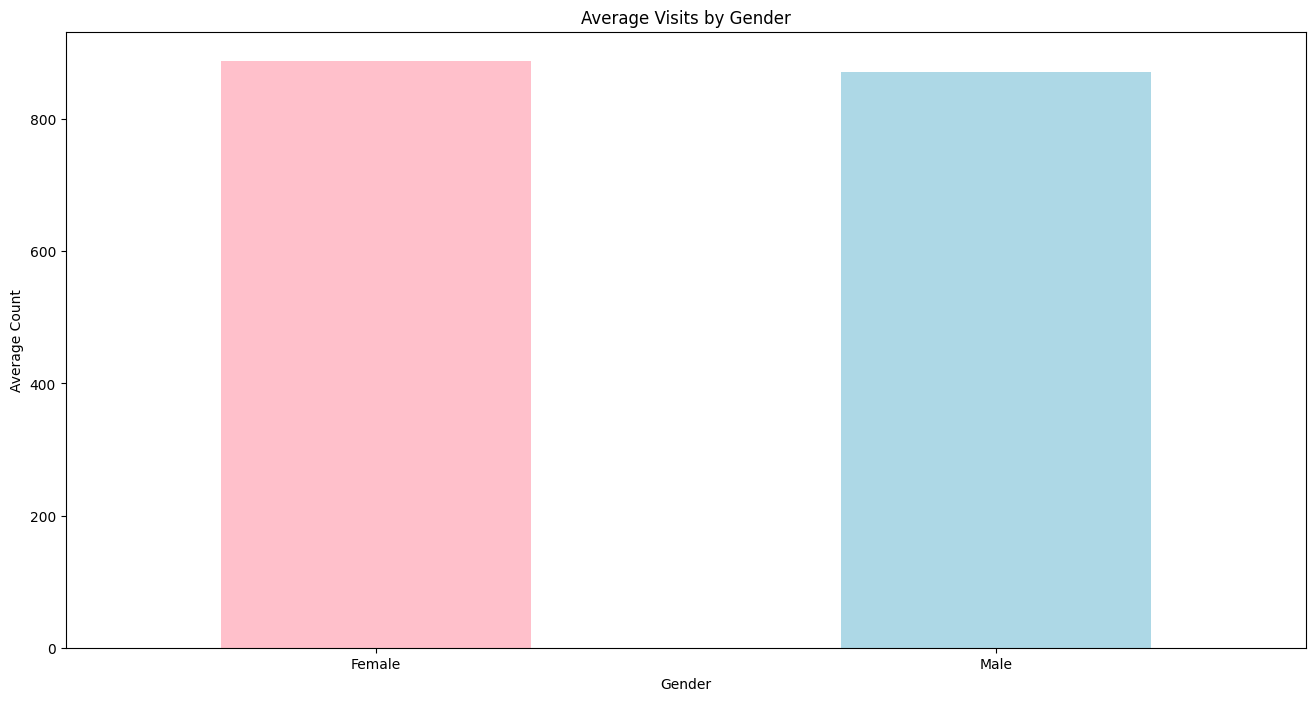

In [45]:
df_gender = df2[df2['Variable'].str.contains("Female|Male")].copy()
df_gender.loc[:, 'Gender'] = df_gender['Variable'].str.extract(r'(Female|Male)')[0]
average_counts = df_gender.groupby('Gender')['Count'].mean()
fig, ax = plt.subplots(figsize=(16, 8))
average_counts.plot(kind='bar', ax=ax, color=['pink', 'lightblue'])
plt.title('Average Visits by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Count')
plt.xticks(rotation=0)
plt.show()

In [46]:
df3.fillna(method='ffill', inplace=True)
df3.columns = ['_'.join(col).strip() if 'Unnamed' not in col[0] else '_'.join(col[1:]).strip() for col in df3.columns.values]
df3.rename(columns={df3.columns[0]: 'Time'}, inplace=True)

df3 = df3.melt(id_vars=[df3.columns[0]], var_name='Variable', value_name='Count')


Average Stay Days - Mean: 37.26, Median: 16.00
Median Stay Days - Mean: 29.04, Median: 10.00


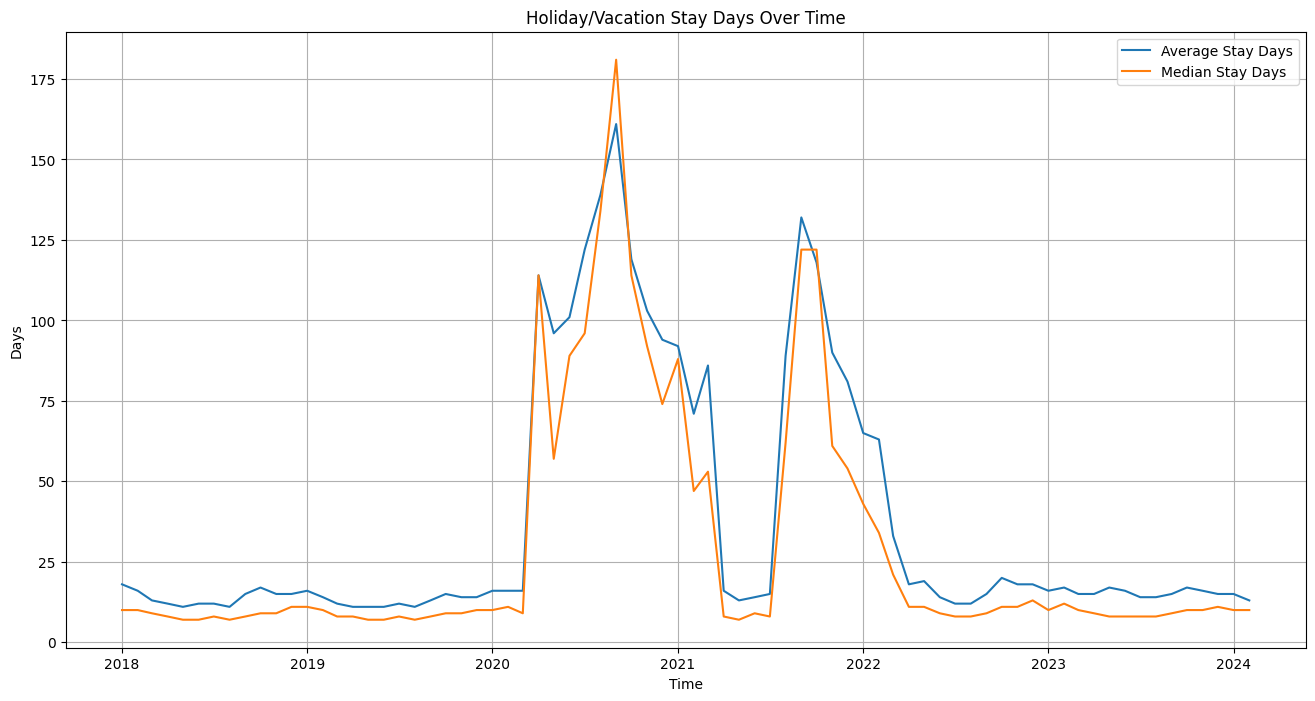

In [47]:
filtered_data = df3[df3['Variable'].str.contains('Holiday/Vacation_.*stay days')].copy()

filtered_data['Time'] = pd.to_datetime(filtered_data['Time'], format='%YM%m')

average_data = filtered_data[filtered_data['Variable'].str.contains('Average')]
median_data = filtered_data[filtered_data['Variable'].str.contains('Median')]

average_mean = average_data['Count'].mean()
average_median = average_data['Count'].median()
median_mean = median_data['Count'].mean()
median_median = median_data['Count'].median()

print(f"Average Stay Days - Mean: {average_mean:.2f}, Median: {average_median:.2f}")
print(f"Median Stay Days - Mean: {median_mean:.2f}, Median: {median_median:.2f}")

plt.figure(figsize=(16, 8))
plt.plot(average_data['Time'], average_data['Count'], label='Average Stay Days')
plt.plot(median_data['Time'], median_data['Count'], label='Median Stay Days')

plt.title('Holiday/Vacation Stay Days Over Time')
plt.xlabel('Time')
plt.ylabel('Days')
plt.legend()
plt.grid(True)

plt.show()

Average Stay Days - Mean: 40.09, Median: 23.50
Median Stay Days - Mean: 26.46, Median: 12.00


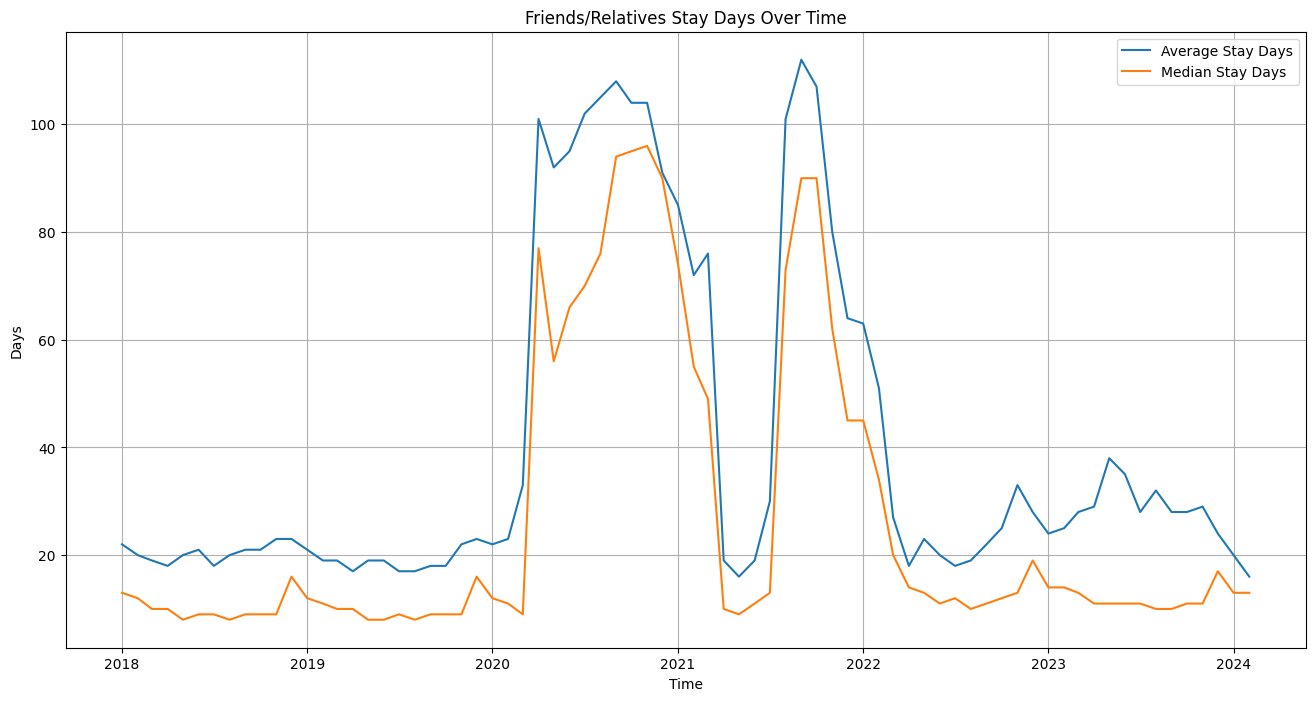

In [48]:
filtered_data = df3[df3['Variable'].str.contains('Visit Friends/Relatives_.*stay days')].copy()

filtered_data['Time'] = pd.to_datetime(filtered_data['Time'], format='%YM%m')

average_data = filtered_data[filtered_data['Variable'].str.contains('Average')]
median_data = filtered_data[filtered_data['Variable'].str.contains('Median')]

average_mean = average_data['Count'].mean()
average_median = average_data['Count'].median()
median_mean = median_data['Count'].mean()
median_median = median_data['Count'].median()

print(f"Average Stay Days - Mean: {average_mean:.2f}, Median: {average_median:.2f}")
print(f"Median Stay Days - Mean: {median_mean:.2f}, Median: {median_median:.2f}")


plt.figure(figsize=(16, 8))
plt.plot(average_data['Time'], average_data['Count'], label='Average Stay Days')
plt.plot(median_data['Time'], median_data['Count'], label='Median Stay Days')


plt.title('Friends/Relatives Stay Days Over Time')
plt.xlabel('Time')
plt.ylabel('Days')
plt.legend()
plt.grid(True)


plt.show()

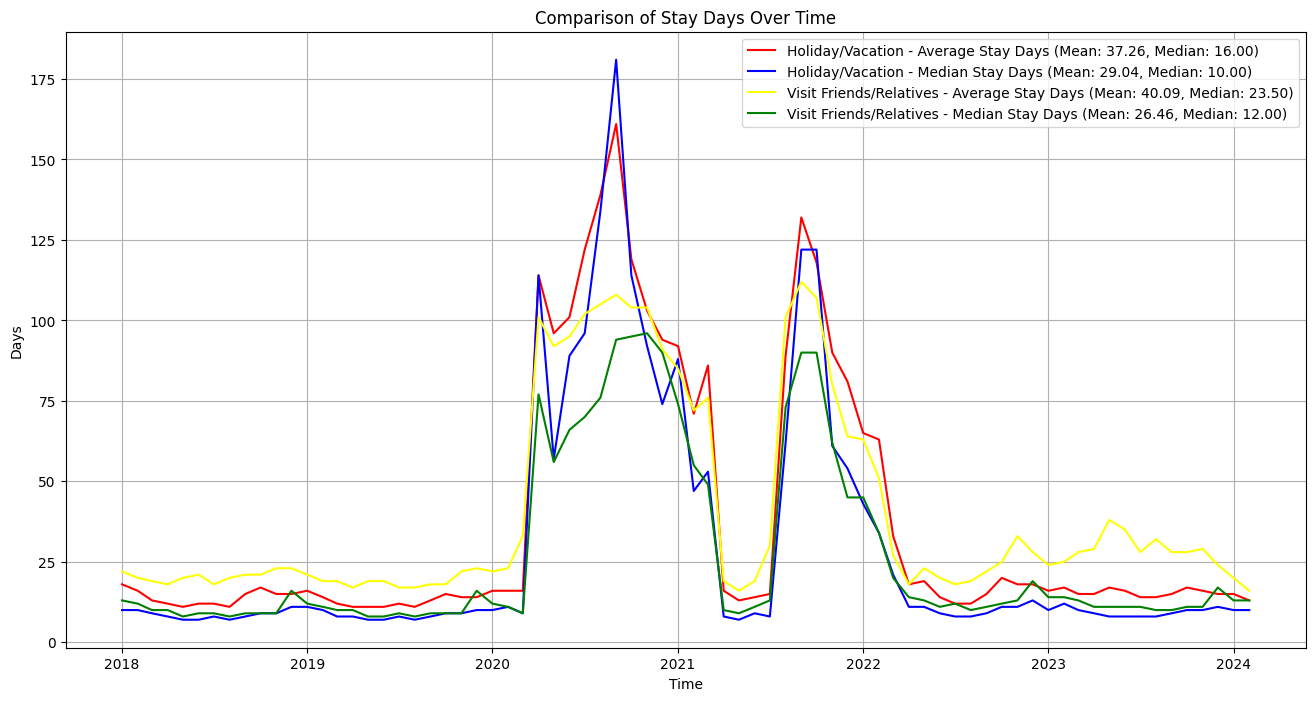

In [49]:
holiday_data = df3[df3['Variable'].str.contains('Holiday/Vacation_.*stay days')].copy()
holiday_data['Time'] = pd.to_datetime(holiday_data['Time'], format='%YM%m')
holiday_avg_data = holiday_data[holiday_data['Variable'].str.contains('Average')]
holiday_median_data = holiday_data[holiday_data['Variable'].str.contains('Median')]

holiday_avg_mean = holiday_avg_data['Count'].mean()
holiday_avg_median = holiday_avg_data['Count'].median()
holiday_median_mean = holiday_median_data['Count'].mean()
holiday_median_median = holiday_median_data['Count'].median()

visit_data = df3[df3['Variable'].str.contains('Visit Friends/Relatives_.*stay days')].copy()
visit_data['Time'] = pd.to_datetime(visit_data['Time'], format='%YM%m')
visit_avg_data = visit_data[visit_data['Variable'].str.contains('Average')]
visit_median_data = visit_data[visit_data['Variable'].str.contains('Median')]

visit_avg_mean = visit_avg_data['Count'].mean()
visit_avg_median = visit_avg_data['Count'].median()
visit_median_mean = visit_median_data['Count'].mean()
visit_median_median = visit_median_data['Count'].median()

plt.figure(figsize=(16, 8))
plt.plot(holiday_avg_data['Time'], holiday_avg_data['Count'], label=f'Holiday/Vacation - Average Stay Days (Mean: {holiday_avg_mean:.2f}, Median: {holiday_avg_median:.2f})', color='red', linestyle='-')
plt.plot(holiday_median_data['Time'], holiday_median_data['Count'], label=f'Holiday/Vacation - Median Stay Days (Mean: {holiday_median_mean:.2f}, Median: {holiday_median_median:.2f})', color='blue', linestyle='-')
plt.plot(visit_avg_data['Time'], visit_avg_data['Count'], label=f'Visit Friends/Relatives - Average Stay Days (Mean: {visit_avg_mean:.2f}, Median: {visit_avg_median:.2f})', color='yellow', linestyle='-')
plt.plot(visit_median_data['Time'], visit_median_data['Count'], label=f'Visit Friends/Relatives - Median Stay Days (Mean: {visit_median_mean:.2f}, Median: {visit_median_median:.2f})', color='green', linestyle='-')

plt.title('Comparison of Stay Days Over Time')
plt.xlabel('Time')
plt.ylabel('Days')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
df6.replace('..', pd.NA, inplace=True)

df6 = df6.apply(pd.to_numeric, errors='ignore')
column_means = df6.mean(numeric_only=True)

df6.fillna(column_means, inplace=True)

In [51]:
mean_values = df6.drop(columns=['Time']).mean(numeric_only=True)
median_values = df6.drop(columns=['Time']).median(numeric_only=True)
stats = pd.DataFrame({'mean': mean_values, 'median': median_values})
stats['score'] = stats['mean'] + stats['median']
top_columns = stats.sort_values(by='score', ascending=False).head(5).index
final_columns = ['Time'] + top_columns.tolist()
df6 = df6[final_columns]

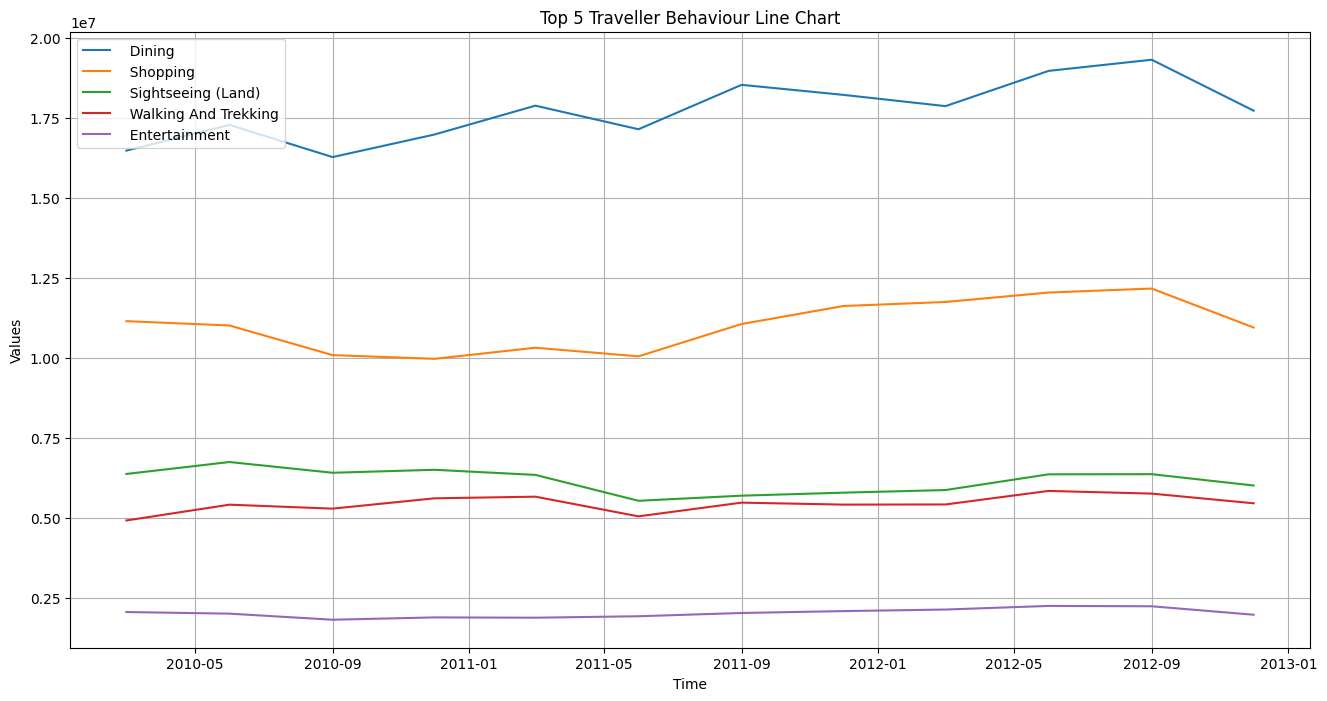

In [52]:
df6['Time'] = pd.to_datetime(df6['Time'])
plt.figure(figsize=(16, 8))


for column in df6.columns.drop('Time'):
    plt.plot(df6['Time'], df6[column], label=column)

plt.title('Top 5 Traveller Behaviour Line Chart')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
df9.dropna(subset=['destination', 'coordinates', 'count'], inplace=True) 

map = folium.Map(location=[-41.2865, 174.7762], zoom_start=5)
HeatMap(data=df9[['Latitude', 'Longitude', 'count']].values.tolist(), radius=15).add_to(map)
color_map = cm.linear.YlOrRd_09.scale(df9['count'].min(), df9['count'].max())
color_map.caption = 'Count of Events'  
color_map.add_to(map)  

map

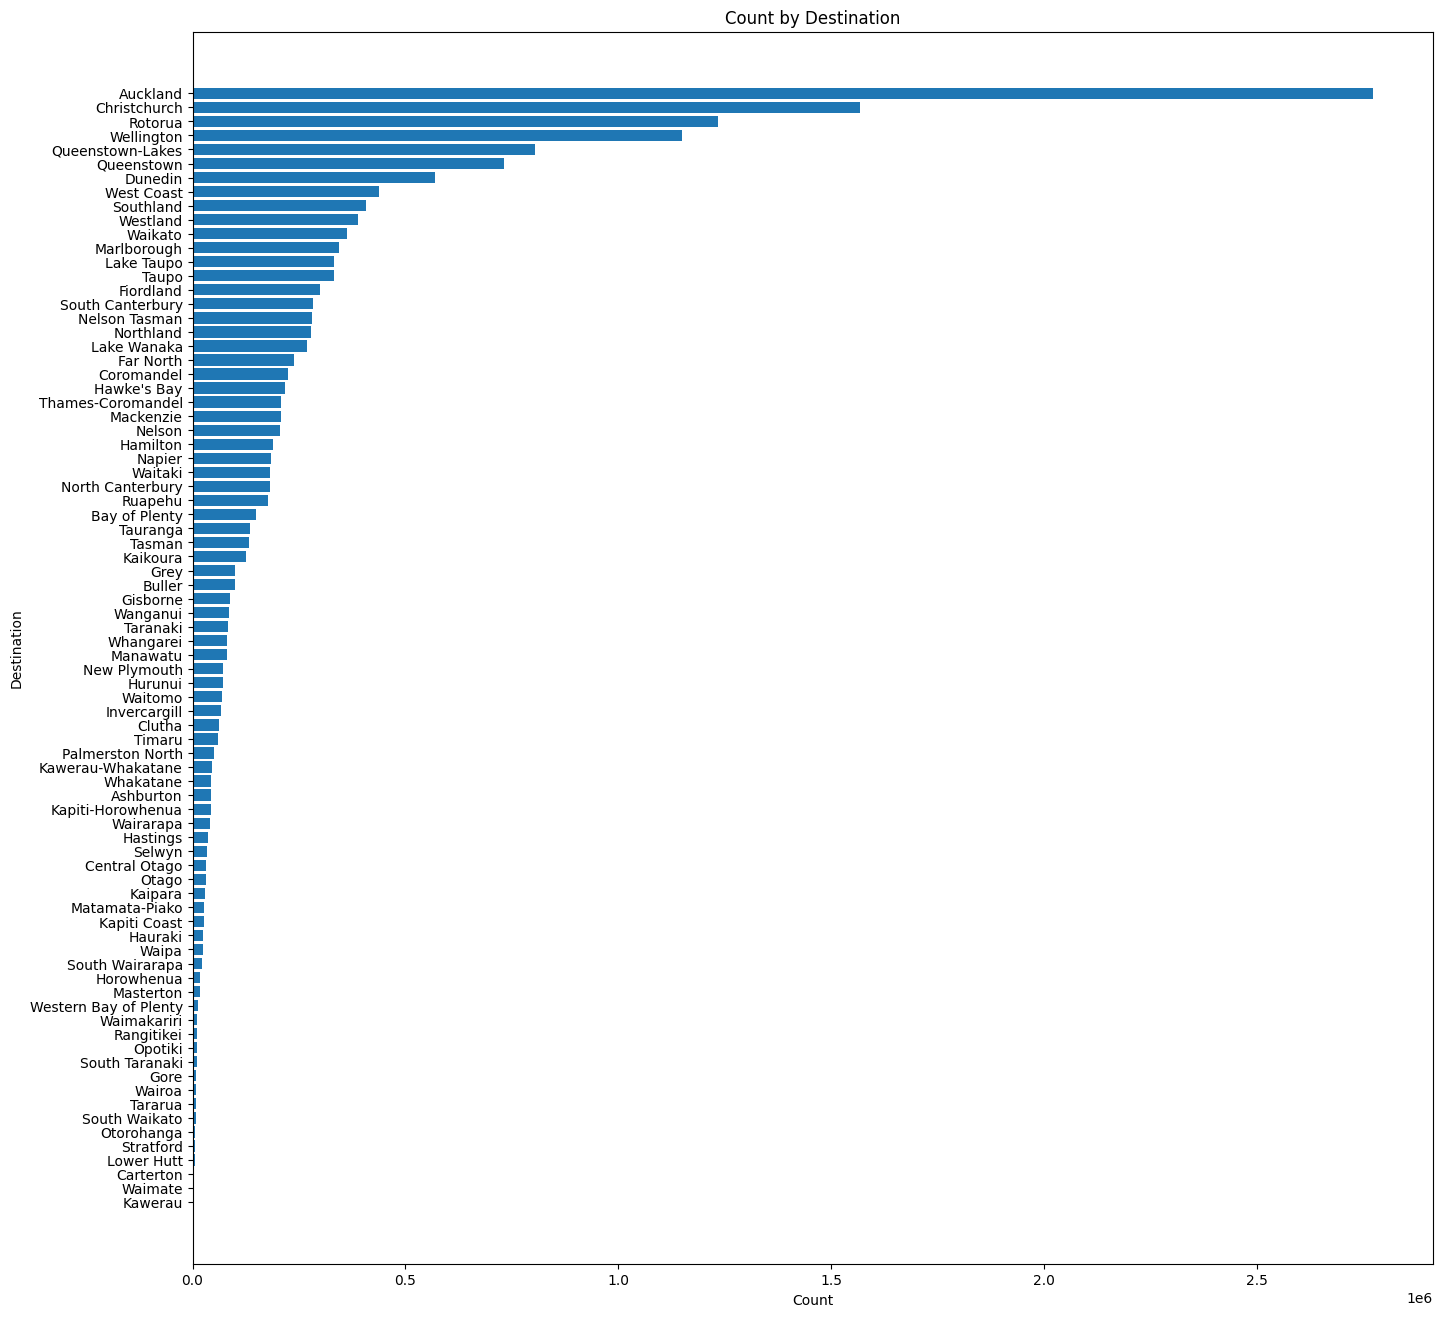

In [54]:
df9 = df9[df9['count'] != 0]
df9_sorted = df9.sort_values('count', ascending=False)

plt.figure(figsize=(16, 16))  
plt.barh(df9_sorted['destination'], df9_sorted['count'])
plt.xlabel('Count')
plt.ylabel('Destination')
plt.title('Count by Destination')
plt.gca().invert_yaxis()
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)  

plt.show()

# Analysis of the characteristics of domestic tourists

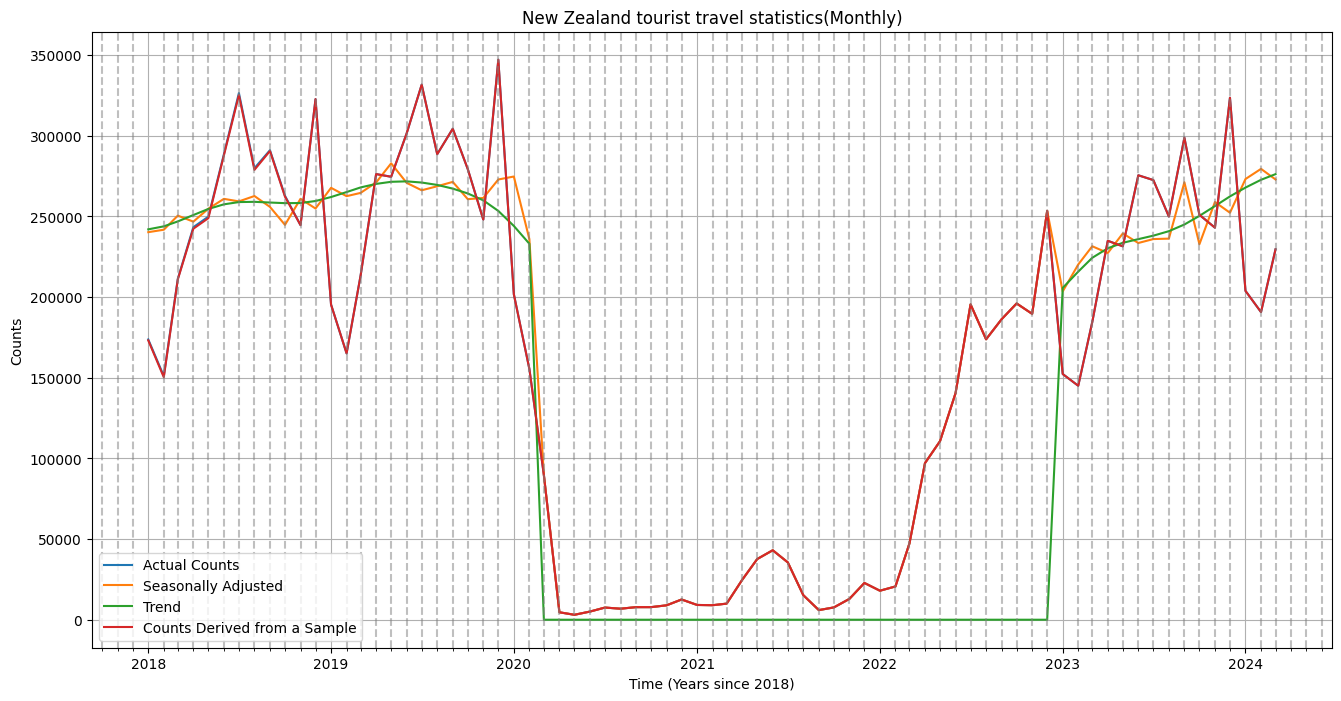

In [55]:
df13.set_index('Time', inplace=True)

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df13.index, df13['Actual Counts'], label='Actual Counts')
ax.plot(df13.index, df13['Seasonally Adjusted'], label='Seasonally Adjusted')
ax.plot(df13.index, df13['Trend'], label='Trend')
ax.plot(df13.index, df13['Counts Derived from a Sample'], label='Counts Derived from a Sample')

ax.set_xlabel('Time (Years since 2018)')
ax.set_ylabel('Counts')
ax.set_title('New Zealand tourist travel statistics(Monthly)')

ax.grid(True)
ax.legend()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())



for tick in ax.xaxis.get_minorticklocs():
    ax.axvline(x=tick, linestyle='--', color='grey', alpha=0.5)

plt.show()

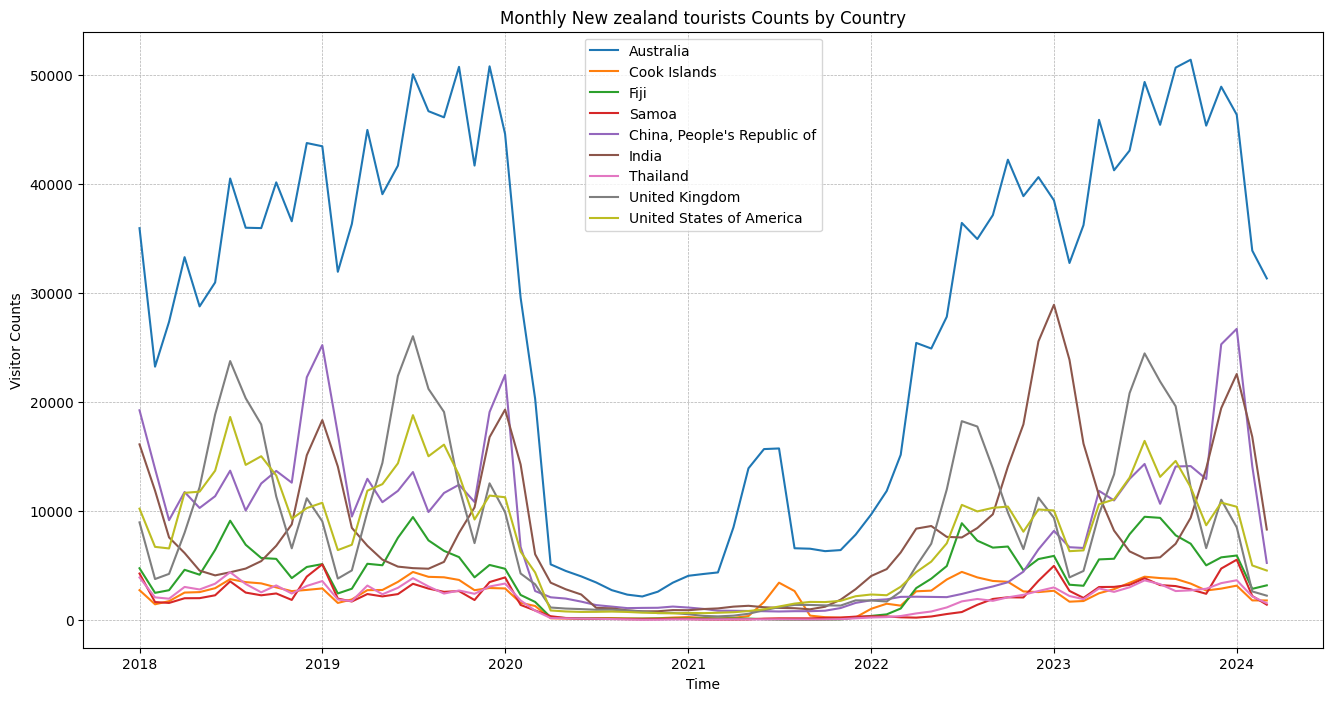

In [56]:
df12.set_index('Time', inplace=True)

plt.figure(figsize=(16, 8))
for column in df12.columns:
    plt.plot(df12.index, df12[column], label=column)

plt.xlabel('Time')
plt.ylabel('Visitor Counts')
plt.title('Monthly New zealand tourists Counts by Country')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

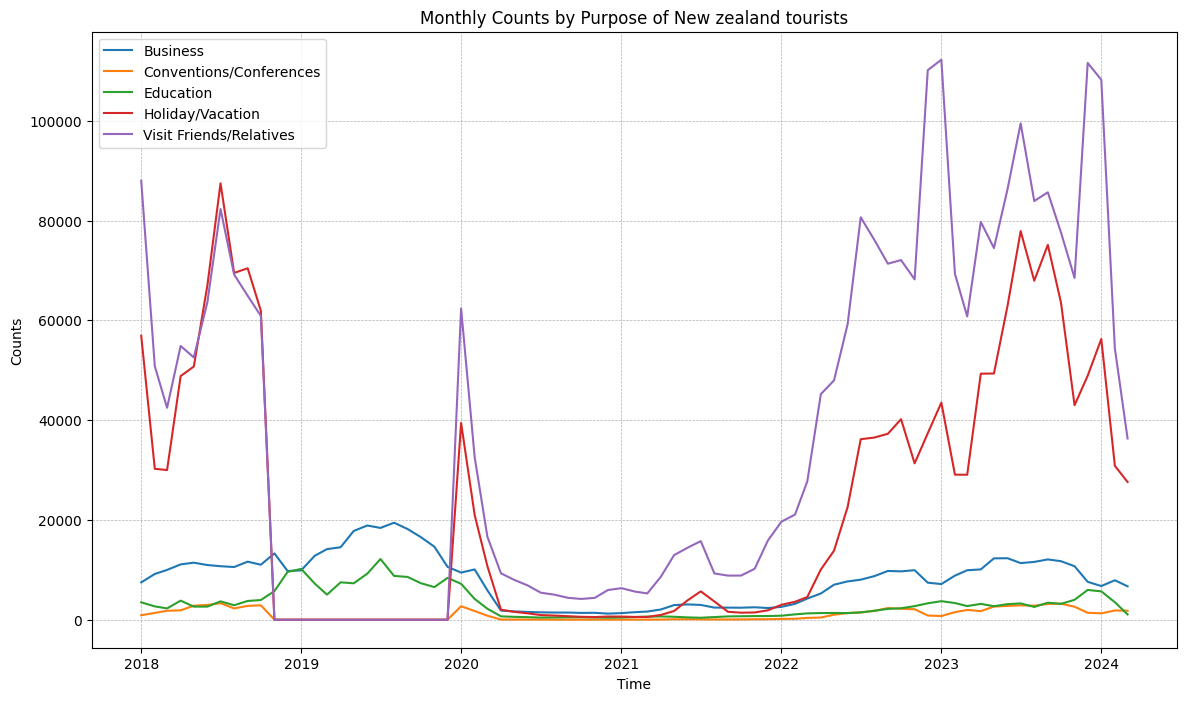

In [57]:
df11.set_index('Time', inplace=True)

plt.figure(figsize=(14, 8))
for column in df11.columns:
    plt.plot(df11.index, df11[column], label=column)

plt.xlabel('Time')
plt.ylabel('Counts')
plt.title('Monthly Counts by Purpose of New zealand tourists')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()